In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel('data_1000_samples_clean.xlsx')
df

,Time,Temp,Weather,Wind,Humidity,Barometer,Visibility,Day,Month,Year
0,12:00 SA,22,Passing clouds.,4,88,1016,100,1,3,2022
1,12:30 SA,22,Passing clouds.,4,88,1015,100,1,3,2022
2,1:00 SA,22,Passing clouds.,4,83,1015,100,1,3,2022
3,1:30 SA,21,Passing clouds.,4,88,1015,8,1,3,2022
4,2:00 SA,21,Passing clouds.,2,88,1015,8,1,3,2022
...,...,...,...,...,...,...,...,...,...,...
996,5:00 CH,28,Passing clouds.,19,79,1009,100,22,3,2022
997,5:30 CH,28,Passing clouds.,13,79,1009,100,22,3,2022
998,6:00 CH,27,Passing clouds.,11,84,1009,100,22,3,2022
999,6:30 CH,27,Passing clouds.,11,84,1009,100,22,3,2022


### Feature Engineering: Window Features

In [6]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #chỉ số label
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #chỉ số tra

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def train(self):
        return self.make_dataset(self.train_df)

    def val(self):
        return self.make_dataset(self.val_df)

    def test(self):
        return self.make_dataset(self.test_df)

In [7]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window


In [8]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):

    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.test))
        self._example = result
    return result

In [10]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
OUT_STEPS = 24
def multi_window_func(train_df,val_df,test_df):
    multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                              train_df = train_df,
                              val_df = val_df,
                              test_df = test_df,
                              label_columns = ['Temp','Wind','Humidity','Barometer'])
    return multi_window

In [12]:
multi_window_list = []
for i in range(0,df.shape[0] - 48*2,48*2):
    train_df = df[['Temp','Wind','Humidity','Barometer']][i:i+48]
    val_df = df[['Temp','Wind','Humidity','Barometer']][i+48:i+48*2]
    test_df = df[['Temp','Wind','Humidity','Barometer']][i+48:i+48*2]
    multi_window_list.append(multi_window_func(train_df,val_df,test_df))

In [13]:
len(multi_window_list)

10

## Training

In [14]:
import tensorflow as tf
from sklearn.metrics import r2_score
MAX_EPOCHS = 200
def r_squared(y_true, y_pred):

    mean_true = tf.reduce_mean(y_true)
    total_sum_squares = tf.reduce_sum(tf.square(y_true - mean_true))
    residual_sum_squares = tf.reduce_sum(tf.square(y_true - y_pred))
    r2 = 1 - (residual_sum_squares / total_sum_squares)
    return r2

def compile_and_fit(model, window, patience=2):

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[r_squared,tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val)
    return history


#### 1.Model Linear

In [15]:
num_features = train_df.shape[1]
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -12:, :]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [16]:
Table_Linear = []

In [17]:
Total_r_squared = 0
Total_mean_absolute_error = 0
Total_val_r_squared = 0
Total_val_mean_absolute_error = 0


for multi_window in multi_window_list:
    history = compile_and_fit(multi_linear_model, multi_window)
    r_squared_ = round(history.history['r_squared'][-1],4)
    mean_absolute_error_ = round(history.history['mean_absolute_error'][-1],4)
    val_r_squared_ = round(history.history['val_r_squared'][-1],4)
    val_mean_absolute_error_ = round(history.history['val_mean_absolute_error'][-1],4)
    Table_Linear.append([r_squared_,mean_absolute_error_,val_r_squared_,val_mean_absolute_error_])
    Total_r_squared = Total_r_squared + r_squared_
    Total_mean_absolute_error = Total_mean_absolute_error + mean_absolute_error_
    Total_val_r_squared = Total_val_r_squared + val_r_squared_
    Total_val_mean_absolute_error = Total_val_mean_absolute_error + val_mean_absolute_error_
    
Total_r_squared = Total_r_squared/len(multi_window_list)
Total_mean_absolute_error = Total_mean_absolute_error/len(multi_window_list)
Total_val_r_squared = Total_val_r_squared/len(multi_window_list)
Total_val_mean_absolute_error = Total_val_mean_absolute_error/len(multi_window_list)
Table_Linear.append([Total_r_squared,Total_mean_absolute_error,Total_val_r_squared,Total_val_mean_absolute_error])

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 259096.8906 - r_squared: -0.4414 - mean_absolute_error: 281.6875 - val_loss: 252141.4375 - val_r_squared: -0.4015 - val_mean_absolute_error: 271.8050
Epoch 2/200
1/1 [==============================] - 0s 68ms/step - loss: 251705.2500 - r_squared: -0.4003 - mean_absolute_error: 269.7612 - val_loss: 244990.5000 - val_r_squared: -0.3617 - val_mean_absolute_error: 264.0699
Epoch 3/200
1/1 [==============================] - 0s 72ms/step - loss: 244628.9375 - r_squared: -0.3609 - mean_absolute_error: 261.7872 - val_loss: 238061.2344 - val_r_squared: -0.3232 - val_mean_absolute_error: 259.2858
Epoch 4/200
1/1 [==============================] - 0s 78ms/step - loss: 237781.5469 - r_squared: -0.3229 - mean_absolute_error: 256.8185 - val_loss: 231315.1406 - val_r_squared: -0.2857 - val_mean_absolute_error: 252.9871
Epoch 5/200
1/1 [==============================] - 0s 83ms/step - loss: 231119.0000 - r_squared: -0.2858 - mean_ab

Epoch 76/200
1/1 [==============================] - 0s 65ms/step - loss: 11584.4092 - r_squared: 0.9356 - mean_absolute_error: 54.0686 - val_loss: 10447.7656 - val_r_squared: 0.9419 - val_mean_absolute_error: 53.8637
Epoch 77/200
1/1 [==============================] - 0s 64ms/step - loss: 10924.9580 - r_squared: 0.9392 - mean_absolute_error: 52.5112 - val_loss: 9830.9980 - val_r_squared: 0.9454 - val_mean_absolute_error: 52.3285
Epoch 78/200
1/1 [==============================] - 0s 71ms/step - loss: 10297.5527 - r_squared: 0.9427 - mean_absolute_error: 51.0108 - val_loss: 9245.0850 - val_r_squared: 0.9486 - val_mean_absolute_error: 50.8207
Epoch 79/200
1/1 [==============================] - 0s 72ms/step - loss: 9700.9521 - r_squared: 0.9460 - mean_absolute_error: 49.5471 - val_loss: 8688.7920 - val_r_squared: 0.9517 - val_mean_absolute_error: 49.3361
Epoch 80/200
1/1 [==============================] - 0s 72ms/step - loss: 9133.9316 - r_squared: 0.9492 - mean_absolute_error: 48.0710 - 

1/1 [==============================] - 0s 72ms/step - loss: 823.9879 - r_squared: 0.9954 - mean_absolute_error: 14.4018 - val_loss: 627.8397 - val_r_squared: 0.9965 - val_mean_absolute_error: 15.0993
Epoch 115/200
1/1 [==============================] - 0s 64ms/step - loss: 758.7132 - r_squared: 0.9958 - mean_absolute_error: 13.8135 - val_loss: 573.5005 - val_r_squared: 0.9968 - val_mean_absolute_error: 14.5349
Epoch 116/200
1/1 [==============================] - 0s 64ms/step - loss: 698.0826 - r_squared: 0.9961 - mean_absolute_error: 13.2447 - val_loss: 523.3229 - val_r_squared: 0.9971 - val_mean_absolute_error: 13.9854
Epoch 117/200
1/1 [==============================] - 0s 64ms/step - loss: 641.7968 - r_squared: 0.9964 - mean_absolute_error: 12.6969 - val_loss: 477.0359 - val_r_squared: 0.9973 - val_mean_absolute_error: 13.4512
Epoch 118/200
1/1 [==============================] - 0s 69ms/step - loss: 589.5903 - r_squared: 0.9967 - mean_absolute_error: 12.1686 - val_loss: 434.3892 - v

Epoch 153/200
1/1 [==============================] - 0s 64ms/step - loss: 16.4218 - r_squared: 0.9999 - mean_absolute_error: 2.0318 - val_loss: 22.8932 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1426
Epoch 154/200
1/1 [==============================] - 0s 68ms/step - loss: 14.4907 - r_squared: 0.9999 - mean_absolute_error: 1.9086 - val_loss: 22.6122 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0739
Epoch 155/200
1/1 [==============================] - 0s 72ms/step - loss: 12.7640 - r_squared: 0.9999 - mean_absolute_error: 1.7907 - val_loss: 22.4472 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0198
Epoch 156/200
1/1 [==============================] - 0s 64ms/step - loss: 11.2237 - r_squared: 0.9999 - mean_absolute_error: 1.6786 - val_loss: 22.3834 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0082
Epoch 157/200
1/1 [==============================] - 0s 64ms/step - loss: 9.8502 - r_squared: 0.9999 - mean_absolute_error: 1.5724 - val_loss: 22.4076 - val_r_s

1/1 [==============================] - 0s 72ms/step - loss: 2.2250 - r_squared: 1.0000 - mean_absolute_error: 1.3015 - val_loss: 28.1201 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.4812
Epoch 32/200
1/1 [==============================] - 0s 64ms/step - loss: 2.1750 - r_squared: 1.0000 - mean_absolute_error: 1.3390 - val_loss: 26.9274 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3034
Epoch 33/200
1/1 [==============================] - 0s 63ms/step - loss: 1.6916 - r_squared: 1.0000 - mean_absolute_error: 1.1842 - val_loss: 25.8729 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.0550
Epoch 34/200
1/1 [==============================] - 0s 64ms/step - loss: 1.2364 - r_squared: 1.0000 - mean_absolute_error: 0.9133 - val_loss: 25.5476 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.8962
Epoch 35/200
1/1 [==============================] - 0s 64ms/step - loss: 1.1694 - r_squared: 1.0000 - mean_absolute_error: 0.9626 - val_loss: 25.8564 - val_r_squared: 0.9999 - val_m

1/1 [==============================] - 0s 64ms/step - loss: 9.1211e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0269 - val_loss: 25.7833 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1441
Epoch 110/200
1/1 [==============================] - 0s 64ms/step - loss: 6.9230e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0240 - val_loss: 25.7227 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1385
Epoch 111/200
1/1 [==============================] - 0s 64ms/step - loss: 4.8359e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0185 - val_loss: 25.6690 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1331
Epoch 112/200
1/1 [==============================] - 0s 64ms/step - loss: 5.7473e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0217 - val_loss: 25.6614 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1312
Epoch 113/200
1/1 [==============================] - 0s 64ms/step - loss: 5.8213e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0218 - val_loss: 25.7038 - val_r

1/1 [==============================] - 0s 80ms/step - loss: 2.9263e-07 - r_squared: 1.0000 - mean_absolute_error: 4.5070e-04 - val_loss: 25.7351 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1386
Epoch 186/200
1/1 [==============================] - 0s 80ms/step - loss: 3.0001e-07 - r_squared: 1.0000 - mean_absolute_error: 4.7859e-04 - val_loss: 25.7346 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1385
Epoch 187/200
1/1 [==============================] - 0s 81ms/step - loss: 2.3860e-07 - r_squared: 1.0000 - mean_absolute_error: 4.4911e-04 - val_loss: 25.7337 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1384
Epoch 188/200
1/1 [==============================] - 0s 80ms/step - loss: 2.1226e-07 - r_squared: 1.0000 - mean_absolute_error: 3.8895e-04 - val_loss: 25.7330 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1384
Epoch 189/200
1/1 [==============================] - 0s 80ms/step - loss: 2.0573e-07 - r_squared: 1.0000 - mean_absolute_error: 4.0620e-04 - val_l

Epoch 24/200
1/1 [==============================] - 0s 69ms/step - loss: 3.3514 - r_squared: 1.0000 - mean_absolute_error: 1.7042 - val_loss: 11.1090 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8213
Epoch 25/200
1/1 [==============================] - 0s 65ms/step - loss: 2.9297 - r_squared: 1.0000 - mean_absolute_error: 1.5405 - val_loss: 10.2294 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.6948
Epoch 26/200
1/1 [==============================] - 0s 74ms/step - loss: 2.8080 - r_squared: 1.0000 - mean_absolute_error: 1.4049 - val_loss: 9.3733 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.4742
Epoch 27/200
1/1 [==============================] - 0s 72ms/step - loss: 2.9484 - r_squared: 1.0000 - mean_absolute_error: 1.5052 - val_loss: 8.4234 - val_r_squared: 1.0000 - val_mean_absolute_error: 2.2770
Epoch 28/200
1/1 [==============================] - 0s 73ms/step - loss: 2.8280 - r_squared: 1.0000 - mean_absolute_error: 1.5321 - val_loss: 7.4611 - val_r_squared: 1.00

Epoch 103/200
1/1 [==============================] - 0s 64ms/step - loss: 7.9070e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0235 - val_loss: 6.8275 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7435
Epoch 104/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0011 - r_squared: 1.0000 - mean_absolute_error: 0.0291 - val_loss: 6.8118 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7397
Epoch 105/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0014 - r_squared: 1.0000 - mean_absolute_error: 0.0336 - val_loss: 6.8049 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7377
Epoch 106/200
1/1 [==============================] - 0s 64ms/step - loss: 9.2223e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0275 - val_loss: 6.8111 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7384
Epoch 107/200
1/1 [==============================] - 0s 64ms/step - loss: 5.4585e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0188 - val_loss: 6.8275 - val_

Epoch 142/200
1/1 [==============================] - 0s 65ms/step - loss: 3.0137e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0052 - val_loss: 6.8339 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7411
Epoch 143/200
1/1 [==============================] - 0s 73ms/step - loss: 2.0651e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0041 - val_loss: 6.8291 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7414
Epoch 144/200
1/1 [==============================] - 0s 80ms/step - loss: 1.2337e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0028 - val_loss: 6.8234 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7409
Epoch 145/200
1/1 [==============================] - 0s 73ms/step - loss: 2.0862e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0043 - val_loss: 6.8210 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7401
Epoch 146/200
1/1 [==============================] - 0s 80ms/step - loss: 1.8294e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0039 - val_loss: 6.823

1/1 [==============================] - 0s 64ms/step - loss: 4.4209 - r_squared: 1.0000 - mean_absolute_error: 1.7299 - val_loss: 82.2963 - val_r_squared: 0.9995 - val_mean_absolute_error: 7.6061
Epoch 19/200
1/1 [==============================] - 0s 64ms/step - loss: 4.8073 - r_squared: 1.0000 - mean_absolute_error: 1.9173 - val_loss: 74.0756 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.4352
Epoch 20/200
1/1 [==============================] - 0s 64ms/step - loss: 8.3145 - r_squared: 1.0000 - mean_absolute_error: 2.6884 - val_loss: 69.2346 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2019
Epoch 21/200
1/1 [==============================] - 0s 64ms/step - loss: 10.3090 - r_squared: 0.9999 - mean_absolute_error: 2.9460 - val_loss: 67.6496 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.9504
Epoch 22/200
1/1 [==============================] - 0s 65ms/step - loss: 8.9899 - r_squared: 0.9999 - mean_absolute_error: 2.6343 - val_loss: 70.5825 - val_r_squared: 0.9996 - val_

1/1 [==============================] - 0s 64ms/step - loss: 0.0044 - r_squared: 1.0000 - mean_absolute_error: 0.0619 - val_loss: 78.6143 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2739
Epoch 97/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0048 - r_squared: 1.0000 - mean_absolute_error: 0.0638 - val_loss: 78.4501 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2698
Epoch 98/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0027 - r_squared: 1.0000 - mean_absolute_error: 0.0443 - val_loss: 78.2006 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2612
Epoch 99/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0020 - r_squared: 1.0000 - mean_absolute_error: 0.0343 - val_loss: 78.0115 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2535
Epoch 100/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0029 - r_squared: 1.0000 - mean_absolute_error: 0.0503 - val_loss: 77.9779 - val_r_squared: 0.9996 - val_

Epoch 135/200
1/1 [==============================] - 0s 56ms/step - loss: 5.5941e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0066 - val_loss: 78.2554 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2599
Epoch 136/200
1/1 [==============================] - 0s 56ms/step - loss: 6.0276e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 78.2698 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2610
Epoch 137/200
1/1 [==============================] - 0s 60ms/step - loss: 7.1596e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0077 - val_loss: 78.2785 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2616
Epoch 138/200
1/1 [==============================] - 0s 56ms/step - loss: 5.4293e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 78.2797 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2615
Epoch 139/200
1/1 [==============================] - 0s 56ms/step - loss: 3.1881e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0047 - val_loss: 7

1/1 [==============================] - 0s 64ms/step - loss: 16.7588 - r_squared: 0.9999 - mean_absolute_error: 3.6715 - val_loss: 26.7903 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.0004
Epoch 12/200
1/1 [==============================] - 0s 64ms/step - loss: 10.8089 - r_squared: 0.9999 - mean_absolute_error: 2.5048 - val_loss: 30.6547 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.2476
Epoch 13/200
1/1 [==============================] - 0s 64ms/step - loss: 12.4211 - r_squared: 0.9999 - mean_absolute_error: 2.8641 - val_loss: 35.3489 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.9646
Epoch 14/200
1/1 [==============================] - 0s 56ms/step - loss: 16.7690 - r_squared: 0.9999 - mean_absolute_error: 3.7324 - val_loss: 34.0153 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.0170
Epoch 15/200
1/1 [==============================] - 0s 56ms/step - loss: 16.7489 - r_squared: 0.9999 - mean_absolute_error: 3.7802 - val_loss: 26.7588 - val_r_squared: 0.9999 - 

1/1 [==============================] - 0s 64ms/step - loss: 0.0059 - r_squared: 1.0000 - mean_absolute_error: 0.0683 - val_loss: 14.8605 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9892
Epoch 90/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0053 - r_squared: 1.0000 - mean_absolute_error: 0.0625 - val_loss: 14.8475 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9833
Epoch 91/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0058 - r_squared: 1.0000 - mean_absolute_error: 0.0670 - val_loss: 14.8284 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9800
Epoch 92/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0058 - r_squared: 1.0000 - mean_absolute_error: 0.0660 - val_loss: 14.8149 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9798
Epoch 93/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0048 - r_squared: 1.0000 - mean_absolute_error: 0.0599 - val_loss: 14.8188 - val_r_squared: 0.9999 - val_m

Epoch 128/200
1/1 [==============================] - 0s 64ms/step - loss: 1.2243e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0089 - val_loss: 14.8474 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9842
Epoch 129/200
1/1 [==============================] - 0s 56ms/step - loss: 1.1656e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0096 - val_loss: 14.8330 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9825
Epoch 130/200
1/1 [==============================] - 0s 64ms/step - loss: 1.1043e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0096 - val_loss: 14.8278 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9817
Epoch 131/200
1/1 [==============================] - 0s 56ms/step - loss: 7.4881e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0079 - val_loss: 14.8335 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9821
Epoch 132/200
1/1 [==============================] - 0s 64ms/step - loss: 6.7642e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 1

1/1 [==============================] - 0s 64ms/step - loss: 52.8323 - r_squared: 0.9997 - mean_absolute_error: 6.5747 - val_loss: 79.2710 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.9096
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 67.3252 - r_squared: 0.9996 - mean_absolute_error: 7.7696 - val_loss: 49.7230 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1453
Epoch 6/200
1/1 [==============================] - 0s 56ms/step - loss: 39.2610 - r_squared: 0.9998 - mean_absolute_error: 5.9984 - val_loss: 21.7650 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4135
Epoch 7/200
1/1 [==============================] - 0s 56ms/step - loss: 10.9094 - r_squared: 0.9999 - mean_absolute_error: 2.8920 - val_loss: 23.6287 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.9531
Epoch 8/200
1/1 [==============================] - 0s 64ms/step - loss: 11.3473 - r_squared: 0.9999 - mean_absolute_error: 2.7652 - val_loss: 43.6928 - val_r_squared: 0.9998 - val_

1/1 [==============================] - 0s 56ms/step - loss: 0.0168 - r_squared: 1.0000 - mean_absolute_error: 0.1208 - val_loss: 13.7744 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.4009
Epoch 83/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0112 - r_squared: 1.0000 - mean_absolute_error: 0.0873 - val_loss: 13.7557 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3904
Epoch 84/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0097 - r_squared: 1.0000 - mean_absolute_error: 0.0882 - val_loss: 13.7033 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3905
Epoch 85/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0117 - r_squared: 1.0000 - mean_absolute_error: 0.0989 - val_loss: 13.6401 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3903
Epoch 86/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0111 - r_squared: 1.0000 - mean_absolute_error: 0.0943 - val_loss: 13.6043 - val_r_squared: 0.9999 - val_m

1/1 [==============================] - 0s 64ms/step - loss: 4.3213e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 13.6897 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3862
Epoch 160/200
1/1 [==============================] - 0s 56ms/step - loss: 3.7484e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 13.6897 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3865
Epoch 161/200
1/1 [==============================] - 0s 56ms/step - loss: 5.2152e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 13.6900 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3870
Epoch 162/200
1/1 [==============================] - 0s 56ms/step - loss: 4.6124e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0018 - val_loss: 13.6900 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3874
Epoch 163/200
1/1 [==============================] - 0s 56ms/step - loss: 2.9902e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0016 - val_loss: 13.6895 - val_r

1/1 [==============================] - 0s 64ms/step - loss: 1.0701 - r_squared: 1.0000 - mean_absolute_error: 0.9256 - val_loss: 22.6870 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6417
Epoch 37/200
1/1 [==============================] - 0s 56ms/step - loss: 1.1349 - r_squared: 1.0000 - mean_absolute_error: 0.9633 - val_loss: 24.2342 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.8123
Epoch 38/200
1/1 [==============================] - 0s 59ms/step - loss: 1.1007 - r_squared: 1.0000 - mean_absolute_error: 0.9620 - val_loss: 25.4558 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.9096
Epoch 39/200
1/1 [==============================] - 0s 56ms/step - loss: 0.9537 - r_squared: 1.0000 - mean_absolute_error: 0.8064 - val_loss: 26.0078 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.9154
Epoch 40/200
1/1 [==============================] - 0s 65ms/step - loss: 0.8326 - r_squared: 1.0000 - mean_absolute_error: 0.8071 - val_loss: 25.7848 - val_r_squared: 0.9999 - val_m

1/1 [==============================] - 0s 56ms/step - loss: 4.6257e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0192 - val_loss: 23.4157 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6613
Epoch 115/200
1/1 [==============================] - 0s 56ms/step - loss: 2.8586e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0147 - val_loss: 23.4313 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6647
Epoch 116/200
1/1 [==============================] - 0s 56ms/step - loss: 3.7089e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0176 - val_loss: 23.4303 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6658
Epoch 117/200
1/1 [==============================] - 0s 56ms/step - loss: 4.4199e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0190 - val_loss: 23.4154 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6646
Epoch 118/200
1/1 [==============================] - 0s 64ms/step - loss: 3.0594e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0153 - val_loss: 23.3975 - val_r

1/1 [==============================] - 0s 56ms/step - loss: 1.6236e-07 - r_squared: 1.0000 - mean_absolute_error: 3.4832e-04 - val_loss: 23.4057 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6616
Epoch 191/200
1/1 [==============================] - 0s 64ms/step - loss: 1.4675e-07 - r_squared: 1.0000 - mean_absolute_error: 3.2998e-04 - val_loss: 23.4062 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6616
Epoch 192/200
1/1 [==============================] - 0s 56ms/step - loss: 1.8528e-07 - r_squared: 1.0000 - mean_absolute_error: 3.9600e-04 - val_loss: 23.4056 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6616
Epoch 193/200
1/1 [==============================] - 0s 56ms/step - loss: 1.4602e-07 - r_squared: 1.0000 - mean_absolute_error: 3.2342e-04 - val_loss: 23.4045 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6615
Epoch 194/200
1/1 [==============================] - 0s 62ms/step - loss: 1.0651e-07 - r_squared: 1.0000 - mean_absolute_error: 2.8866e-04 - val_l

Epoch 29/200
1/1 [==============================] - 0s 64ms/step - loss: 2.0905 - r_squared: 1.0000 - mean_absolute_error: 1.2646 - val_loss: 58.0764 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1346
Epoch 30/200
1/1 [==============================] - 0s 56ms/step - loss: 2.1331 - r_squared: 1.0000 - mean_absolute_error: 1.3038 - val_loss: 62.7127 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.4025
Epoch 31/200
1/1 [==============================] - 0s 64ms/step - loss: 2.2057 - r_squared: 1.0000 - mean_absolute_error: 1.3069 - val_loss: 66.7186 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.6186
Epoch 32/200
1/1 [==============================] - 0s 66ms/step - loss: 2.0180 - r_squared: 1.0000 - mean_absolute_error: 1.2842 - val_loss: 68.6485 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.6871
Epoch 33/200
1/1 [==============================] - 0s 57ms/step - loss: 1.6008 - r_squared: 1.0000 - mean_absolute_error: 1.1502 - val_loss: 68.1490 - val_r_squared: 0

1/1 [==============================] - 0s 64ms/step - loss: 6.4288e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0212 - val_loss: 60.9536 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1747
Epoch 108/200
1/1 [==============================] - 0s 56ms/step - loss: 7.3220e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0234 - val_loss: 60.9243 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1752
Epoch 109/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0010 - r_squared: 1.0000 - mean_absolute_error: 0.0301 - val_loss: 60.9126 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1739
Epoch 110/200
1/1 [==============================] - 0s 64ms/step - loss: 7.6090e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0251 - val_loss: 60.9310 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1718
Epoch 111/200
1/1 [==============================] - 0s 56ms/step - loss: 3.6514e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0157 - val_loss: 60.9712 - val_r_squ

1/1 [==============================] - 0s 64ms/step - loss: 3.5214e-07 - r_squared: 1.0000 - mean_absolute_error: 5.1789e-04 - val_loss: 60.9668 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1727
Epoch 184/200
1/1 [==============================] - 0s 57ms/step - loss: 3.7682e-07 - r_squared: 1.0000 - mean_absolute_error: 5.4050e-04 - val_loss: 60.9654 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1727
Epoch 185/200
1/1 [==============================] - 0s 56ms/step - loss: 2.8110e-07 - r_squared: 1.0000 - mean_absolute_error: 4.8459e-04 - val_loss: 60.9623 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1727
Epoch 186/200
1/1 [==============================] - 0s 64ms/step - loss: 2.4765e-07 - r_squared: 1.0000 - mean_absolute_error: 4.1480e-04 - val_loss: 60.9602 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1726
Epoch 187/200
1/1 [==============================] - 0s 56ms/step - loss: 2.8338e-07 - r_squared: 1.0000 - mean_absolute_error: 4.7624e-04 - val_l

Epoch 22/200
1/1 [==============================] - 0s 65ms/step - loss: 5.6435 - r_squared: 1.0000 - mean_absolute_error: 1.9871 - val_loss: 26.2698 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.7831
Epoch 23/200
1/1 [==============================] - 0s 56ms/step - loss: 4.9060 - r_squared: 1.0000 - mean_absolute_error: 2.0042 - val_loss: 25.6296 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.7584
Epoch 24/200
1/1 [==============================] - 0s 56ms/step - loss: 3.7562 - r_squared: 1.0000 - mean_absolute_error: 1.8365 - val_loss: 24.8046 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.7408
Epoch 25/200
1/1 [==============================] - 0s 64ms/step - loss: 2.7626 - r_squared: 1.0000 - mean_absolute_error: 1.4363 - val_loss: 24.4904 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.7034
Epoch 26/200
1/1 [==============================] - 0s 56ms/step - loss: 2.6612 - r_squared: 1.0000 - mean_absolute_error: 1.4060 - val_loss: 24.6221 - val_r_squared: 0

1/1 [==============================] - 0s 65ms/step - loss: 0.0021 - r_squared: 1.0000 - mean_absolute_error: 0.0398 - val_loss: 21.1299 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1908
Epoch 101/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0019 - r_squared: 1.0000 - mean_absolute_error: 0.0397 - val_loss: 21.0872 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1871
Epoch 102/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0014 - r_squared: 1.0000 - mean_absolute_error: 0.0323 - val_loss: 21.0434 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1796
Epoch 103/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0012 - r_squared: 1.0000 - mean_absolute_error: 0.0309 - val_loss: 21.0245 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1739
Epoch 104/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0014 - r_squared: 1.0000 - mean_absolute_error: 0.0332 - val_loss: 21.0324 - val_r_squared: 0.9999 - v

Epoch 139/200
1/1 [==============================] - 0s 56ms/step - loss: 3.0257e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0049 - val_loss: 21.0670 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1782
Epoch 140/200
1/1 [==============================] - 0s 56ms/step - loss: 3.3065e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0050 - val_loss: 21.0683 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1788
Epoch 141/200
1/1 [==============================] - 0s 64ms/step - loss: 3.1354e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0050 - val_loss: 21.0683 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1786
Epoch 142/200
1/1 [==============================] - 0s 56ms/step - loss: 2.4140e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0044 - val_loss: 21.0659 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1778
Epoch 143/200
1/1 [==============================] - 0s 72ms/step - loss: 1.9858e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0039 - val_loss: 2

1/1 [==============================] - 0s 56ms/step - loss: 14.7406 - r_squared: 0.9999 - mean_absolute_error: 3.7260 - val_loss: 22.3231 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.1045
Epoch 16/200
1/1 [==============================] - 0s 55ms/step - loss: 11.9809 - r_squared: 0.9999 - mean_absolute_error: 3.1214 - val_loss: 24.2498 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.2603
Epoch 17/200
1/1 [==============================] - 0s 57ms/step - loss: 6.8438 - r_squared: 1.0000 - mean_absolute_error: 2.0385 - val_loss: 28.2426 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.4566
Epoch 18/200
1/1 [==============================] - 0s 64ms/step - loss: 4.5287 - r_squared: 1.0000 - mean_absolute_error: 1.8784 - val_loss: 32.2997 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.5693
Epoch 19/200
1/1 [==============================] - 0s 57ms/step - loss: 5.3197 - r_squared: 1.0000 - mean_absolute_error: 2.1169 - val_loss: 32.7302 - val_r_squared: 0.9998 - val

1/1 [==============================] - 0s 56ms/step - loss: 0.0049 - r_squared: 1.0000 - mean_absolute_error: 0.0647 - val_loss: 17.2045 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4290
Epoch 94/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0027 - r_squared: 1.0000 - mean_absolute_error: 0.0446 - val_loss: 17.3147 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4381
Epoch 95/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0023 - r_squared: 1.0000 - mean_absolute_error: 0.0405 - val_loss: 17.3544 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4419
Epoch 96/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0035 - r_squared: 1.0000 - mean_absolute_error: 0.0556 - val_loss: 17.3000 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4382
Epoch 97/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0030 - r_squared: 1.0000 - mean_absolute_error: 0.0479 - val_loss: 17.2007 - val_r_squared: 0.9999 - val_m

Epoch 132/200
1/1 [==============================] - 0s 64ms/step - loss: 7.9838e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0081 - val_loss: 17.2340 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4336
Epoch 133/200
1/1 [==============================] - 0s 56ms/step - loss: 6.1153e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0069 - val_loss: 17.2293 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4335
Epoch 134/200
1/1 [==============================] - 0s 56ms/step - loss: 4.8269e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0062 - val_loss: 17.2190 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4323
Epoch 135/200
1/1 [==============================] - 0s 64ms/step - loss: 5.4457e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0064 - val_loss: 17.2130 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4312
Epoch 136/200
1/1 [==============================] - 0s 56ms/step - loss: 5.0930e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 1

In [18]:
df_Table_Linear = pd.DataFrame(Table_Linear, columns=['r_squared','mean_absolute_error','val_r_squared','val_mean_absolute_error'])
df_Table_Linear.rename(index={df_Table_Linear.index[-1]: 'Total'}, inplace=True)
df_Table_Linear

,r_squared,mean_absolute_error,val_r_squared,val_mean_absolute_error
0,1.0,0.03160,0.99980,4.37620
1,1.0,0.00020,0.99990,4.13840
2,1.0,0.00020,1.00000,1.74040
3,1.0,0.00030,0.99960,7.26040
4,1.0,0.00030,0.99990,2.98330
5,1.0,0.00020,0.99990,2.38680
6,1.0,0.00020,0.99990,3.66150
7,1.0,0.00020,0.99970,6.17270
8,1.0,0.00020,0.99990,3.17750
9,1.0,0.00030,0.99990,3.43210


In [19]:
multi_linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 12, 4)             0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 96)                4704      
                                                                 
 reshape (Reshape)           (None, 24, 4)             0         
                                                                 
Total params: 4,704
Trainable params: 4,704
Non-trainable params: 0
_________________________________________________________________


#### 2.Model Dense

In [20]:
num_features = train_df.shape[1]
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -12:, :]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [21]:
Table_Dense = []

In [22]:

Total_r_squared = 0
Total_mean_absolute_error = 0
Total_val_r_squared = 0
Total_val_mean_absolute_error = 0


for multi_window in multi_window_list:
    history = compile_and_fit(multi_dense_model, multi_window)
    r_squared_ = round(history.history['r_squared'][-1],4)
    mean_absolute_error_ = round(history.history['mean_absolute_error'][-1],4)
    val_r_squared_ = round(history.history['val_r_squared'][-1],4)
    val_mean_absolute_error_ = round(history.history['val_mean_absolute_error'][-1],4)
    Table_Dense.append([r_squared_,mean_absolute_error_,val_r_squared_,val_mean_absolute_error_])
    Total_r_squared = Total_r_squared + r_squared_
    Total_mean_absolute_error = Total_mean_absolute_error + mean_absolute_error_
    Total_val_r_squared = Total_val_r_squared + val_r_squared_
    Total_val_mean_absolute_error = Total_val_mean_absolute_error + val_mean_absolute_error_
    
Total_r_squared = Total_r_squared/len(multi_window_list)
Total_mean_absolute_error = Total_mean_absolute_error/len(multi_window_list)
Total_val_r_squared = Total_val_r_squared/len(multi_window_list)
Total_val_mean_absolute_error = Total_val_mean_absolute_error/len(multi_window_list)
Table_Dense.append([Total_r_squared,Total_mean_absolute_error,Total_val_r_squared,Total_val_mean_absolute_error])

Epoch 1/200
1/1 [==============================] - 1s 722ms/step - loss: 259096.8906 - r_squared: -0.4414 - mean_absolute_error: 281.6875 - val_loss: 233168.4375 - val_r_squared: -0.2960 - val_mean_absolute_error: 266.2917
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 232745.3281 - r_squared: -0.2948 - mean_absolute_error: 263.7708 - val_loss: 205768.1250 - val_r_squared: -0.1437 - val_mean_absolute_error: 242.2583
Epoch 3/200
1/1 [==============================] - 0s 56ms/step - loss: 205563.7969 - r_squared: -0.1436 - mean_absolute_error: 242.5338 - val_loss: 177994.2031 - val_r_squared: 0.0106 - val_mean_absolute_error: 228.4028
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 177974.6875 - r_squared: 0.0099 - mean_absolute_error: 230.1545 - val_loss: 149430.6406 - val_r_squared: 0.1694 - val_mean_absolute_error: 217.6068
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 149506.2969 - r_squared: 0.1682 - mean_abs

Epoch 39/200
1/1 [==============================] - 0s 57ms/step - loss: 583.0034 - r_squared: 0.9968 - mean_absolute_error: 15.4713 - val_loss: 135.3102 - val_r_squared: 0.9992 - val_mean_absolute_error: 8.6367
Epoch 40/200
1/1 [==============================] - 0s 57ms/step - loss: 132.5242 - r_squared: 0.9993 - mean_absolute_error: 7.9860 - val_loss: 42.6345 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.2720
Epoch 41/200
1/1 [==============================] - 0s 65ms/step - loss: 16.1319 - r_squared: 0.9999 - mean_absolute_error: 3.5675 - val_loss: 232.8887 - val_r_squared: 0.9987 - val_mean_absolute_error: 11.4304
Epoch 42/200
1/1 [==============================] - 0s 57ms/step - loss: 180.7728 - r_squared: 0.9990 - mean_absolute_error: 9.6441 - val_loss: 599.8318 - val_r_squared: 0.9967 - val_mean_absolute_error: 16.1524
Epoch 43/200
1/1 [==============================] - 0s 56ms/step - loss: 521.8538 - r_squared: 0.9971 - mean_absolute_error: 14.3433 - val_loss: 1022.8213 

Epoch 78/200
1/1 [==============================] - 0s 64ms/step - loss: 5.2624 - r_squared: 1.0000 - mean_absolute_error: 1.6094 - val_loss: 25.7868 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5834
Epoch 79/200
1/1 [==============================] - 0s 56ms/step - loss: 0.4431 - r_squared: 1.0000 - mean_absolute_error: 0.5272 - val_loss: 24.7905 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3044
Epoch 80/200
1/1 [==============================] - 0s 64ms/step - loss: 3.7487 - r_squared: 1.0000 - mean_absolute_error: 1.3151 - val_loss: 29.1317 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.0358
Epoch 81/200
1/1 [==============================] - 0s 56ms/step - loss: 12.3000 - r_squared: 0.9999 - mean_absolute_error: 2.1281 - val_loss: 35.5418 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.6188
Epoch 82/200
1/1 [==============================] - 0s 64ms/step - loss: 22.2425 - r_squared: 0.9999 - mean_absolute_error: 2.7548 - val_loss: 41.1947 - val_r_squared:

1/1 [==============================] - 0s 56ms/step - loss: 0.0065 - r_squared: 1.0000 - mean_absolute_error: 0.0492 - val_loss: 24.5429 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3792
Epoch 157/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0118 - r_squared: 1.0000 - mean_absolute_error: 0.0608 - val_loss: 24.6037 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3870
Epoch 158/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0153 - r_squared: 1.0000 - mean_absolute_error: 0.0702 - val_loss: 24.6069 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3892
Epoch 159/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0158 - r_squared: 1.0000 - mean_absolute_error: 0.0713 - val_loss: 24.5582 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3839
Epoch 160/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0131 - r_squared: 1.0000 - mean_absolute_error: 0.0646 - val_loss: 24.4825 - val_r_squared: 0.9999 - v

Epoch 195/200
1/1 [==============================] - 0s 56ms/step - loss: 2.0666e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0082 - val_loss: 24.3198 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3347
Epoch 196/200
1/1 [==============================] - 0s 56ms/step - loss: 2.8763e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0098 - val_loss: 24.3178 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3345
Epoch 197/200
1/1 [==============================] - 0s 64ms/step - loss: 3.0250e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0096 - val_loss: 24.3091 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3335
Epoch 198/200
1/1 [==============================] - 0s 56ms/step - loss: 2.5185e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0090 - val_loss: 24.3002 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3323
Epoch 199/200
1/1 [==============================] - 0s 56ms/step - loss: 1.6185e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0071 - val_loss: 2

1/1 [==============================] - 0s 64ms/step - loss: 1.1928 - r_squared: 1.0000 - mean_absolute_error: 0.8053 - val_loss: 16.7663 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8440
Epoch 73/200
1/1 [==============================] - 0s 56ms/step - loss: 2.0430 - r_squared: 1.0000 - mean_absolute_error: 1.2975 - val_loss: 17.3193 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9159
Epoch 74/200
1/1 [==============================] - 0s 64ms/step - loss: 2.2877 - r_squared: 1.0000 - mean_absolute_error: 1.4001 - val_loss: 17.2617 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9093
Epoch 75/200
1/1 [==============================] - 0s 56ms/step - loss: 1.5543 - r_squared: 1.0000 - mean_absolute_error: 1.1493 - val_loss: 17.2461 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9328
Epoch 76/200
1/1 [==============================] - 0s 64ms/step - loss: 0.7583 - r_squared: 1.0000 - mean_absolute_error: 0.6929 - val_loss: 17.8246 - val_r_squared: 0.9999 - val_m

1/1 [==============================] - 0s 64ms/step - loss: 5.0789e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0170 - val_loss: 16.2430 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8425
Epoch 151/200
1/1 [==============================] - 0s 56ms/step - loss: 6.1361e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0202 - val_loss: 16.2432 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8415
Epoch 152/200
1/1 [==============================] - 0s 57ms/step - loss: 6.2075e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0194 - val_loss: 16.2254 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8379
Epoch 153/200
1/1 [==============================] - 0s 64ms/step - loss: 4.4339e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0156 - val_loss: 16.1999 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8336
Epoch 154/200
1/1 [==============================] - 0s 57ms/step - loss: 3.2949e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0129 - val_loss: 16.1813 - val_r

Epoch 27/200
1/1 [==============================] - 0s 64ms/step - loss: 282.2360 - r_squared: 0.9984 - mean_absolute_error: 15.5412 - val_loss: 206.0148 - val_r_squared: 0.9988 - val_mean_absolute_error: 13.0749
Epoch 28/200
1/1 [==============================] - 0s 56ms/step - loss: 217.1334 - r_squared: 0.9988 - mean_absolute_error: 13.5222 - val_loss: 74.5372 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.9570
Epoch 29/200
1/1 [==============================] - 0s 64ms/step - loss: 78.4711 - r_squared: 0.9996 - mean_absolute_error: 8.2508 - val_loss: 16.8960 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1282
Epoch 30/200
1/1 [==============================] - 0s 56ms/step - loss: 11.0854 - r_squared: 0.9999 - mean_absolute_error: 2.6051 - val_loss: 73.6349 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.3124
Epoch 31/200
1/1 [==============================] - 0s 64ms/step - loss: 58.6519 - r_squared: 0.9997 - mean_absolute_error: 6.6658 - val_loss: 159.9279 - val_

Epoch 106/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0307 - r_squared: 1.0000 - mean_absolute_error: 0.1516 - val_loss: 5.9138 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4982
Epoch 107/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0461 - r_squared: 1.0000 - mean_absolute_error: 0.1934 - val_loss: 5.9063 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.5137
Epoch 108/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0582 - r_squared: 1.0000 - mean_absolute_error: 0.1990 - val_loss: 5.9424 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4925
Epoch 109/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0392 - r_squared: 1.0000 - mean_absolute_error: 0.1326 - val_loss: 6.0216 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4772
Epoch 110/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0208 - r_squared: 1.0000 - mean_absolute_error: 0.1237 - val_loss: 6.1106 - val_r_squared: 1

Epoch 184/200
1/1 [==============================] - 0s 56ms/step - loss: 1.8361e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 5.9729 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4389
Epoch 185/200
1/1 [==============================] - 0s 64ms/step - loss: 1.9698e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0039 - val_loss: 5.9734 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4381
Epoch 186/200
1/1 [==============================] - 0s 64ms/step - loss: 1.0034e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0023 - val_loss: 5.9738 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4371
Epoch 187/200
1/1 [==============================] - 0s 56ms/step - loss: 9.3147e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0026 - val_loss: 5.9741 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.4368
Epoch 188/200
1/1 [==============================] - 0s 66ms/step - loss: 1.4519e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0033 - val_loss: 5.974

1/1 [==============================] - 0s 64ms/step - loss: 3.9638 - r_squared: 1.0000 - mean_absolute_error: 1.8034 - val_loss: 44.8297 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1952
Epoch 62/200
1/1 [==============================] - 0s 56ms/step - loss: 3.5608 - r_squared: 1.0000 - mean_absolute_error: 1.7107 - val_loss: 44.3718 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.8174
Epoch 63/200
1/1 [==============================] - 0s 56ms/step - loss: 2.3131 - r_squared: 1.0000 - mean_absolute_error: 1.3075 - val_loss: 44.0135 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.8024
Epoch 64/200
1/1 [==============================] - 0s 62ms/step - loss: 1.7855 - r_squared: 1.0000 - mean_absolute_error: 1.0598 - val_loss: 43.8499 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.9041
Epoch 65/200
1/1 [==============================] - 0s 64ms/step - loss: 2.2917 - r_squared: 1.0000 - mean_absolute_error: 1.3641 - val_loss: 42.6324 - val_r_squared: 0.9998 - val_m

1/1 [==============================] - 0s 64ms/step - loss: 0.0012 - r_squared: 1.0000 - mean_absolute_error: 0.0303 - val_loss: 39.9382 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.6012
Epoch 140/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0011 - r_squared: 1.0000 - mean_absolute_error: 0.0295 - val_loss: 39.9118 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.6046
Epoch 141/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0011 - r_squared: 1.0000 - mean_absolute_error: 0.0281 - val_loss: 39.8574 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.5996
Epoch 142/200
1/1 [==============================] - 0s 64ms/step - loss: 6.7247e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0228 - val_loss: 39.8094 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.5915
Epoch 143/200
1/1 [==============================] - 0s 64ms/step - loss: 6.5280e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0213 - val_loss: 39.8006 - val_r_squared: 0.

1/1 [==============================] - 0s 64ms/step - loss: 413.2873 - r_squared: 0.9977 - mean_absolute_error: 18.7073 - val_loss: 611.8231 - val_r_squared: 0.9966 - val_mean_absolute_error: 22.9756
Epoch 16/200
1/1 [==============================] - 0s 56ms/step - loss: 655.1876 - r_squared: 0.9964 - mean_absolute_error: 23.9173 - val_loss: 570.2975 - val_r_squared: 0.9968 - val_mean_absolute_error: 21.9351
Epoch 17/200
1/1 [==============================] - 0s 64ms/step - loss: 606.5414 - r_squared: 0.9966 - mean_absolute_error: 22.7279 - val_loss: 333.9802 - val_r_squared: 0.9981 - val_mean_absolute_error: 16.2783
Epoch 18/200
1/1 [==============================] - 0s 56ms/step - loss: 352.0673 - r_squared: 0.9981 - mean_absolute_error: 16.6220 - val_loss: 133.2471 - val_r_squared: 0.9993 - val_mean_absolute_error: 8.2973
Epoch 19/200
1/1 [==============================] - 0s 64ms/step - loss: 127.5745 - r_squared: 0.9993 - mean_absolute_error: 8.6475 - val_loss: 120.2155 - val_r_s

1/1 [==============================] - 0s 56ms/step - loss: 6.6713 - r_squared: 1.0000 - mean_absolute_error: 2.1117 - val_loss: 17.9669 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4517
Epoch 55/200
1/1 [==============================] - 0s 64ms/step - loss: 6.6201 - r_squared: 1.0000 - mean_absolute_error: 1.8904 - val_loss: 16.8766 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1107
Epoch 56/200
1/1 [==============================] - 0s 56ms/step - loss: 7.7253 - r_squared: 1.0000 - mean_absolute_error: 2.2956 - val_loss: 14.8866 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8132
Epoch 57/200
1/1 [==============================] - 0s 56ms/step - loss: 7.1618 - r_squared: 1.0000 - mean_absolute_error: 2.3251 - val_loss: 12.6473 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.5057
Epoch 58/200
1/1 [==============================] - 0s 64ms/step - loss: 4.9557 - r_squared: 1.0000 - mean_absolute_error: 1.9337 - val_loss: 12.6396 - val_r_squared: 0.9999 - val_m

1/1 [==============================] - 0s 56ms/step - loss: 0.0017 - r_squared: 1.0000 - mean_absolute_error: 0.0335 - val_loss: 10.5782 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3773
Epoch 133/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0022 - r_squared: 1.0000 - mean_absolute_error: 0.0429 - val_loss: 10.5785 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3766
Epoch 134/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0028 - r_squared: 1.0000 - mean_absolute_error: 0.0454 - val_loss: 10.5321 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3687
Epoch 135/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0022 - r_squared: 1.0000 - mean_absolute_error: 0.0330 - val_loss: 10.4749 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3604
Epoch 136/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0019 - r_squared: 1.0000 - mean_absolute_error: 0.0315 - val_loss: 10.4430 - val_r_squared: 0.9999 - v

Epoch 171/200
1/1 [==============================] - 0s 56ms/step - loss: 3.9212e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0046 - val_loss: 10.4868 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3641
Epoch 172/200
1/1 [==============================] - 0s 56ms/step - loss: 5.4462e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0060 - val_loss: 10.4894 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3648
Epoch 173/200
1/1 [==============================] - 0s 56ms/step - loss: 5.0193e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0056 - val_loss: 10.4975 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3659
Epoch 174/200
1/1 [==============================] - 0s 65ms/step - loss: 3.0554e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0040 - val_loss: 10.5051 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3667
Epoch 175/200
1/1 [==============================] - 0s 56ms/step - loss: 2.9769e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0046 - val_loss: 1

Epoch 48/200
1/1 [==============================] - 0s 73ms/step - loss: 24.0991 - r_squared: 0.9999 - mean_absolute_error: 4.2255 - val_loss: 22.9361 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.9780
Epoch 49/200
1/1 [==============================] - 0s 65ms/step - loss: 14.6599 - r_squared: 0.9999 - mean_absolute_error: 3.5138 - val_loss: 14.0387 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.6746
Epoch 50/200
1/1 [==============================] - 0s 72ms/step - loss: 4.0676 - r_squared: 1.0000 - mean_absolute_error: 1.6693 - val_loss: 17.5039 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2603
Epoch 51/200
1/1 [==============================] - 0s 72ms/step - loss: 4.6258 - r_squared: 1.0000 - mean_absolute_error: 1.7257 - val_loss: 27.8874 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3294
Epoch 52/200
1/1 [==============================] - 0s 72ms/step - loss: 12.0934 - r_squared: 0.9999 - mean_absolute_error: 2.7187 - val_loss: 31.8592 - val_r_squared

1/1 [==============================] - 0s 64ms/step - loss: 0.0057 - r_squared: 1.0000 - mean_absolute_error: 0.0592 - val_loss: 13.6636 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3867
Epoch 127/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0039 - r_squared: 1.0000 - mean_absolute_error: 0.0428 - val_loss: 13.6804 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3834
Epoch 128/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0034 - r_squared: 1.0000 - mean_absolute_error: 0.0499 - val_loss: 13.6879 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3760
Epoch 129/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0040 - r_squared: 1.0000 - mean_absolute_error: 0.0525 - val_loss: 13.6791 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3698
Epoch 130/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0036 - r_squared: 1.0000 - mean_absolute_error: 0.0444 - val_loss: 13.6623 - val_r_squared: 0.9999 - v

Epoch 165/200
1/1 [==============================] - 0s 64ms/step - loss: 8.5302e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0074 - val_loss: 13.6700 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3685
Epoch 166/200
1/1 [==============================] - 0s 56ms/step - loss: 7.7143e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0063 - val_loss: 13.6648 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3673
Epoch 167/200
1/1 [==============================] - 0s 73ms/step - loss: 7.4092e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0052 - val_loss: 13.6617 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3679
Epoch 168/200
1/1 [==============================] - 0s 65ms/step - loss: 6.5729e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0061 - val_loss: 13.6624 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3696
Epoch 169/200
1/1 [==============================] - 0s 56ms/step - loss: 5.6178e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0058 - val_loss: 1

Epoch 42/200
1/1 [==============================] - 0s 57ms/step - loss: 5.5374 - r_squared: 1.0000 - mean_absolute_error: 1.9378 - val_loss: 36.0394 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.7956
Epoch 43/200
1/1 [==============================] - 0s 56ms/step - loss: 14.4597 - r_squared: 0.9999 - mean_absolute_error: 3.4028 - val_loss: 44.1672 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.5373
Epoch 44/200
1/1 [==============================] - 0s 64ms/step - loss: 24.7206 - r_squared: 0.9999 - mean_absolute_error: 4.2850 - val_loss: 40.6602 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.3761
Epoch 45/200
1/1 [==============================] - 0s 58ms/step - loss: 22.9462 - r_squared: 0.9999 - mean_absolute_error: 4.0509 - val_loss: 31.3915 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.4827
Epoch 46/200
1/1 [==============================] - 0s 64ms/step - loss: 14.6114 - r_squared: 0.9999 - mean_absolute_error: 3.2662 - val_loss: 26.3040 - val_r_square

1/1 [==============================] - 0s 64ms/step - loss: 0.0072 - r_squared: 1.0000 - mean_absolute_error: 0.0662 - val_loss: 18.9503 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8858
Epoch 121/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0033 - r_squared: 1.0000 - mean_absolute_error: 0.0509 - val_loss: 19.0605 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9126
Epoch 122/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0047 - r_squared: 1.0000 - mean_absolute_error: 0.0574 - val_loss: 19.1907 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9294
Epoch 123/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0071 - r_squared: 1.0000 - mean_absolute_error: 0.0668 - val_loss: 19.2602 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9239
Epoch 124/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0060 - r_squared: 1.0000 - mean_absolute_error: 0.0660 - val_loss: 19.2520 - val_r_squared: 0.9999 - v

Epoch 159/200
1/1 [==============================] - 0s 65ms/step - loss: 9.5054e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0084 - val_loss: 19.1209 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9027
Epoch 160/200
1/1 [==============================] - 0s 57ms/step - loss: 1.7830e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0112 - val_loss: 19.1230 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9022
Epoch 161/200
1/1 [==============================] - 0s 56ms/step - loss: 1.4106e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0109 - val_loss: 19.1191 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9009
Epoch 162/200
1/1 [==============================] - 0s 64ms/step - loss: 6.2929e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0065 - val_loss: 19.1173 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9013
Epoch 163/200
1/1 [==============================] - 0s 56ms/step - loss: 5.2486e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0064 - val_loss: 1

Epoch 36/200
1/1 [==============================] - 0s 56ms/step - loss: 58.3634 - r_squared: 0.9997 - mean_absolute_error: 6.6193 - val_loss: 37.5064 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.2554
Epoch 37/200
1/1 [==============================] - 0s 64ms/step - loss: 18.6132 - r_squared: 0.9999 - mean_absolute_error: 3.5470 - val_loss: 23.2266 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5620
Epoch 38/200
1/1 [==============================] - 0s 64ms/step - loss: 14.2419 - r_squared: 0.9999 - mean_absolute_error: 3.0173 - val_loss: 43.6885 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.8947
Epoch 39/200
1/1 [==============================] - 0s 56ms/step - loss: 38.4536 - r_squared: 0.9998 - mean_absolute_error: 5.5797 - val_loss: 64.9473 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2075
Epoch 40/200
1/1 [==============================] - 0s 56ms/step - loss: 57.1144 - r_squared: 0.9997 - mean_absolute_error: 6.5532 - val_loss: 63.6329 - val_r_squar

1/1 [==============================] - 0s 64ms/step - loss: 0.0108 - r_squared: 1.0000 - mean_absolute_error: 0.0613 - val_loss: 24.0588 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6438
Epoch 115/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0112 - r_squared: 1.0000 - mean_absolute_error: 0.0910 - val_loss: 24.1379 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6441
Epoch 116/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0212 - r_squared: 1.0000 - mean_absolute_error: 0.1237 - val_loss: 24.2952 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6603
Epoch 117/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0196 - r_squared: 1.0000 - mean_absolute_error: 0.1110 - val_loss: 24.4397 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6829
Epoch 118/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0085 - r_squared: 1.0000 - mean_absolute_error: 0.0580 - val_loss: 24.5084 - val_r_squared: 0.9999 - v

1/1 [==============================] - 0s 72ms/step - loss: 9.4299e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0023 - val_loss: 24.3103 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6772
Epoch 192/200
1/1 [==============================] - 0s 56ms/step - loss: 3.8389e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 24.3082 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6766
Epoch 193/200
1/1 [==============================] - 0s 64ms/step - loss: 3.7991e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0013 - val_loss: 24.3054 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6761
Epoch 194/200
1/1 [==============================] - 0s 64ms/step - loss: 6.9961e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 24.3036 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6758
Epoch 195/200
1/1 [==============================] - 0s 72ms/step - loss: 5.0451e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0017 - val_loss: 24.3041 - val_r

Epoch 30/200
1/1 [==============================] - 0s 56ms/step - loss: 22.3776 - r_squared: 0.9999 - mean_absolute_error: 3.9888 - val_loss: 66.0425 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.2191
Epoch 31/200
1/1 [==============================] - 0s 56ms/step - loss: 37.4155 - r_squared: 0.9998 - mean_absolute_error: 5.1991 - val_loss: 91.4090 - val_r_squared: 0.9995 - val_mean_absolute_error: 7.8638
Epoch 32/200
1/1 [==============================] - 0s 64ms/step - loss: 65.7793 - r_squared: 0.9996 - mean_absolute_error: 7.0541 - val_loss: 89.4253 - val_r_squared: 0.9995 - val_mean_absolute_error: 7.6342
Epoch 33/200
1/1 [==============================] - 0s 56ms/step - loss: 68.4386 - r_squared: 0.9996 - mean_absolute_error: 6.9701 - val_loss: 60.9149 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.6817
Epoch 34/200
1/1 [==============================] - 0s 64ms/step - loss: 44.3304 - r_squared: 0.9997 - mean_absolute_error: 4.9097 - val_loss: 39.3665 - val_r_squar

1/1 [==============================] - 0s 56ms/step - loss: 0.0201 - r_squared: 1.0000 - mean_absolute_error: 0.1298 - val_loss: 20.1420 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8975
Epoch 109/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0231 - r_squared: 1.0000 - mean_absolute_error: 0.1326 - val_loss: 20.1947 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9028
Epoch 110/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0161 - r_squared: 1.0000 - mean_absolute_error: 0.1141 - val_loss: 20.1327 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9116
Epoch 111/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0166 - r_squared: 1.0000 - mean_absolute_error: 0.0940 - val_loss: 20.0071 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9133
Epoch 112/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0209 - r_squared: 1.0000 - mean_absolute_error: 0.1172 - val_loss: 19.8887 - val_r_squared: 0.9999 - v

1/1 [==============================] - 0s 63ms/step - loss: 9.8728e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0029 - val_loss: 19.9907 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8895
Epoch 186/200
1/1 [==============================] - 0s 64ms/step - loss: 9.4489e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0026 - val_loss: 19.9910 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8892
Epoch 187/200
1/1 [==============================] - 0s 64ms/step - loss: 5.0751e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0019 - val_loss: 19.9917 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8888
Epoch 188/200
1/1 [==============================] - 0s 64ms/step - loss: 5.7726e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 19.9916 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8887
Epoch 189/200
1/1 [==============================] - 0s 56ms/step - loss: 4.9846e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 19.9906 - val_r

Epoch 24/200
1/1 [==============================] - 0s 56ms/step - loss: 81.4387 - r_squared: 0.9995 - mean_absolute_error: 6.9348 - val_loss: 60.5022 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.5194
Epoch 25/200
1/1 [==============================] - 0s 56ms/step - loss: 47.6108 - r_squared: 0.9997 - mean_absolute_error: 6.0824 - val_loss: 69.3115 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.4169
Epoch 26/200
1/1 [==============================] - 0s 56ms/step - loss: 51.6607 - r_squared: 0.9997 - mean_absolute_error: 6.6872 - val_loss: 80.4061 - val_r_squared: 0.9995 - val_mean_absolute_error: 8.2418
Epoch 27/200
1/1 [==============================] - 0s 56ms/step - loss: 61.8132 - r_squared: 0.9997 - mean_absolute_error: 7.5081 - val_loss: 69.4515 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.2949
Epoch 28/200
1/1 [==============================] - 0s 64ms/step - loss: 53.9399 - r_squared: 0.9997 - mean_absolute_error: 6.5294 - val_loss: 56.5200 - val_r_squar

1/1 [==============================] - 0s 64ms/step - loss: 0.0281 - r_squared: 1.0000 - mean_absolute_error: 0.1429 - val_loss: 9.5901 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2385
Epoch 103/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0132 - r_squared: 1.0000 - mean_absolute_error: 0.0944 - val_loss: 9.8039 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2824
Epoch 104/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0250 - r_squared: 1.0000 - mean_absolute_error: 0.1358 - val_loss: 9.8720 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2691
Epoch 105/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0296 - r_squared: 1.0000 - mean_absolute_error: 0.1482 - val_loss: 9.7842 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2177
Epoch 106/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0267 - r_squared: 1.0000 - mean_absolute_error: 0.1359 - val_loss: 9.6512 - val_r_squared: 0.9999 - val_me

Epoch 180/200
1/1 [==============================] - 0s 64ms/step - loss: 7.0052e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0024 - val_loss: 9.6344 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2265
Epoch 181/200
1/1 [==============================] - 0s 56ms/step - loss: 9.0711e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0022 - val_loss: 9.6341 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2258
Epoch 182/200
1/1 [==============================] - 0s 64ms/step - loss: 1.0030e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0028 - val_loss: 9.6346 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2256
Epoch 183/200
1/1 [==============================] - 0s 64ms/step - loss: 1.0453e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 9.6361 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2263
Epoch 184/200
1/1 [==============================] - 0s 64ms/step - loss: 4.3162e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0019 - val_loss: 9.636

In [23]:
df_Table_Dense = pd.DataFrame(Table_Dense, columns=['r_squared','mean_absolute_error','val_r_squared','val_mean_absolute_error'])
df_Table_Dense.rename(index={df_Table_Dense.index[-1]: 'Total'}, inplace=True)
df_Table_Dense

,r_squared,mean_absolute_error,val_r_squared,val_mean_absolute_error
0,1.0,0.00530,0.9999,3.32790
1,1.0,0.00160,0.9999,2.83610
2,1.0,0.00110,1.0000,1.43750
3,1.0,0.00130,0.9998,4.59740
4,1.0,0.00140,0.9999,2.36560
5,1.0,0.00110,0.9999,2.36940
6,1.0,0.00130,0.9999,2.90270
7,1.0,0.00080,0.9999,3.67630
8,1.0,0.00110,0.9999,2.88870
9,1.0,0.00090,0.9999,2.22580


In [24]:
multi_dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 12, 4)             0         
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 512)               25088     
                                                                 
 dense_2 (Dense)             (None, 96)                49248     
                                                                 
 reshape_1 (Reshape)         (None, 24, 4)             0         
                                                                 
Total params: 74,336
Trainable params: 74,336
Non-trainable params: 0
_________________________________________________________________


#### 3.Model CNN

In [25]:
num_features = train_df.shape[1]
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -12:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [26]:
Table_CNN = []

In [27]:
Total_r_squared = 0
Total_mean_absolute_error = 0
Total_val_r_squared = 0
Total_val_mean_absolute_error = 0

for multi_window in multi_window_list:
    history = compile_and_fit(multi_conv_model, multi_window)
    r_squared_ = round(history.history['r_squared'][-1],2)
    mean_absolute_error_ = round(history.history['mean_absolute_error'][-1],2)
    val_r_squared_ = round(history.history['val_r_squared'][-1],2)
    val_mean_absolute_error_ = round(history.history['val_mean_absolute_error'][-1],2)
    Table_CNN.append([r_squared_,mean_absolute_error_,val_r_squared_,val_mean_absolute_error_])
    Total_r_squared = Total_r_squared + r_squared_
    Total_mean_absolute_error = Total_mean_absolute_error + mean_absolute_error_
    Total_val_r_squared = Total_val_r_squared + val_r_squared_
    Total_val_mean_absolute_error = Total_val_mean_absolute_error + val_mean_absolute_error_
    
Total_r_squared = Total_r_squared/len(multi_window_list)
Total_mean_absolute_error = Total_mean_absolute_error/len(multi_window_list)
Total_val_r_squared = Total_val_r_squared/len(multi_window_list)
Total_val_mean_absolute_error = Total_val_mean_absolute_error/len(multi_window_list)
Table_CNN.append([Total_r_squared,Total_mean_absolute_error,Total_val_r_squared,Total_val_mean_absolute_error])

Epoch 1/200
1/1 [==============================] - 1s 901ms/step - loss: 259096.8906 - r_squared: -0.4414 - mean_absolute_error: 281.6875 - val_loss: 216375.3750 - val_r_squared: -0.2027 - val_mean_absolute_error: 271.0616
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 216046.7031 - r_squared: -0.2019 - mean_absolute_error: 271.2715 - val_loss: 172152.1875 - val_r_squared: 0.0431 - val_mean_absolute_error: 234.6743
Epoch 3/200
1/1 [==============================] - 0s 56ms/step - loss: 172142.6250 - r_squared: 0.0423 - mean_absolute_error: 234.9475 - val_loss: 131903.2500 - val_r_squared: 0.2668 - val_mean_absolute_error: 209.6028
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 132074.8594 - r_squared: 0.2652 - mean_absolute_error: 211.8810 - val_loss: 95291.3984 - val_r_squared: 0.4703 - val_mean_absolute_error: 186.8188
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 95500.2266 - r_squared: 0.4687 - mean_absolut

Epoch 39/200
1/1 [==============================] - 0s 56ms/step - loss: 194.4513 - r_squared: 0.9989 - mean_absolute_error: 11.9136 - val_loss: 589.6940 - val_r_squared: 0.9967 - val_mean_absolute_error: 17.5400
Epoch 40/200
1/1 [==============================] - 0s 64ms/step - loss: 517.5600 - r_squared: 0.9971 - mean_absolute_error: 15.9507 - val_loss: 997.2769 - val_r_squared: 0.9945 - val_mean_absolute_error: 19.3908
Epoch 41/200
1/1 [==============================] - 0s 56ms/step - loss: 908.8401 - r_squared: 0.9949 - mean_absolute_error: 17.7417 - val_loss: 1375.7476 - val_r_squared: 0.9924 - val_mean_absolute_error: 22.0128
Epoch 42/200
1/1 [==============================] - 0s 64ms/step - loss: 1277.0905 - r_squared: 0.9929 - mean_absolute_error: 20.5583 - val_loss: 1629.4701 - val_r_squared: 0.9909 - val_mean_absolute_error: 24.8018
Epoch 43/200
1/1 [==============================] - 0s 56ms/step - loss: 1526.9904 - r_squared: 0.9915 - mean_absolute_error: 23.6538 - val_loss:

Epoch 78/200
1/1 [==============================] - 0s 56ms/step - loss: 9.9134 - r_squared: 0.9999 - mean_absolute_error: 2.1254 - val_loss: 34.7702 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.4841
Epoch 79/200
1/1 [==============================] - 0s 64ms/step - loss: 19.8119 - r_squared: 0.9999 - mean_absolute_error: 2.6947 - val_loss: 42.3449 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.9826
Epoch 80/200
1/1 [==============================] - 0s 72ms/step - loss: 28.7725 - r_squared: 0.9998 - mean_absolute_error: 3.2303 - val_loss: 47.6637 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.3239
Epoch 81/200
1/1 [==============================] - 0s 56ms/step - loss: 33.9403 - r_squared: 0.9998 - mean_absolute_error: 3.4661 - val_loss: 48.7880 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.4085
Epoch 82/200
1/1 [==============================] - 0s 64ms/step - loss: 34.0468 - r_squared: 0.9998 - mean_absolute_error: 3.4193 - val_loss: 45.5434 - val_r_square

1/1 [==============================] - 0s 73ms/step - loss: 0.0164 - r_squared: 1.0000 - mean_absolute_error: 0.0761 - val_loss: 23.9972 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2290
Epoch 157/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0146 - r_squared: 1.0000 - mean_absolute_error: 0.0728 - val_loss: 23.9383 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2200
Epoch 158/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0104 - r_squared: 1.0000 - mean_absolute_error: 0.0583 - val_loss: 23.8597 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2072
Epoch 159/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0057 - r_squared: 1.0000 - mean_absolute_error: 0.0465 - val_loss: 23.7926 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1918
Epoch 160/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0020 - r_squared: 1.0000 - mean_absolute_error: 0.0323 - val_loss: 23.7500 - val_r_squared: 0.9999 - v

Epoch 195/200
1/1 [==============================] - 0s 56ms/step - loss: 2.7983e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0099 - val_loss: 23.7676 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1766
Epoch 196/200
1/1 [==============================] - 0s 64ms/step - loss: 1.9428e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0084 - val_loss: 23.7631 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1745
Epoch 197/200
1/1 [==============================] - 0s 64ms/step - loss: 9.8046e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0061 - val_loss: 23.7592 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1720
Epoch 198/200
1/1 [==============================] - 0s 64ms/step - loss: 2.7433e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0038 - val_loss: 23.7528 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1696
Epoch 199/200
1/1 [==============================] - 0s 80ms/step - loss: 2.9128e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 2

1/1 [==============================] - 0s 97ms/step - loss: 2.7354 - r_squared: 1.0000 - mean_absolute_error: 1.4329 - val_loss: 16.1248 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8857
Epoch 73/200
1/1 [==============================] - 0s 88ms/step - loss: 1.4045 - r_squared: 1.0000 - mean_absolute_error: 0.8990 - val_loss: 16.8183 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9487
Epoch 74/200
1/1 [==============================] - 0s 88ms/step - loss: 1.4856 - r_squared: 1.0000 - mean_absolute_error: 0.9410 - val_loss: 18.9293 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1908
Epoch 75/200
1/1 [==============================] - 0s 88ms/step - loss: 2.3616 - r_squared: 1.0000 - mean_absolute_error: 1.4052 - val_loss: 20.4973 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3553
Epoch 76/200
1/1 [==============================] - 0s 129ms/step - loss: 2.6217 - r_squared: 1.0000 - mean_absolute_error: 1.4744 - val_loss: 20.6253 - val_r_squared: 0.9999 - val_

1/1 [==============================] - 0s 88ms/step - loss: 7.2840e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0221 - val_loss: 17.3151 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1554
Epoch 151/200
1/1 [==============================] - 0s 97ms/step - loss: 9.5982e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0262 - val_loss: 17.3256 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1565
Epoch 152/200
1/1 [==============================] - 0s 89ms/step - loss: 9.1550e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0245 - val_loss: 17.3263 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1551
Epoch 153/200
1/1 [==============================] - 0s 90ms/step - loss: 5.8996e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0180 - val_loss: 17.3178 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1520
Epoch 154/200
1/1 [==============================] - 0s 73ms/step - loss: 4.3386e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0148 - val_loss: 17.3078 - val_r

1/1 [==============================] - 0s 64ms/step - loss: 73.3760 - r_squared: 0.9996 - mean_absolute_error: 6.9646 - val_loss: 61.8382 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.3206
Epoch 27/200
1/1 [==============================] - 0s 67ms/step - loss: 55.3452 - r_squared: 0.9997 - mean_absolute_error: 5.6302 - val_loss: 202.6060 - val_r_squared: 0.9989 - val_mean_absolute_error: 13.5733
Epoch 28/200
1/1 [==============================] - 0s 72ms/step - loss: 180.6064 - r_squared: 0.9990 - mean_absolute_error: 13.1062 - val_loss: 328.6744 - val_r_squared: 0.9982 - val_mean_absolute_error: 17.1420
Epoch 29/200
1/1 [==============================] - 0s 71ms/step - loss: 295.8060 - r_squared: 0.9983 - mean_absolute_error: 16.6737 - val_loss: 326.7306 - val_r_squared: 0.9982 - val_mean_absolute_error: 16.4843
Epoch 30/200
1/1 [==============================] - 0s 96ms/step - loss: 289.9282 - r_squared: 0.9984 - mean_absolute_error: 15.9268 - val_loss: 210.4192 - val_r_squar

1/1 [==============================] - 0s 80ms/step - loss: 0.0978 - r_squared: 1.0000 - mean_absolute_error: 0.2677 - val_loss: 7.9025 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.9274
Epoch 105/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0508 - r_squared: 1.0000 - mean_absolute_error: 0.1793 - val_loss: 7.5291 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.8385
Epoch 106/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0588 - r_squared: 1.0000 - mean_absolute_error: 0.1948 - val_loss: 7.2081 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.8124
Epoch 107/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0874 - r_squared: 1.0000 - mean_absolute_error: 0.2701 - val_loss: 7.0319 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7921
Epoch 108/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0802 - r_squared: 1.0000 - mean_absolute_error: 0.2561 - val_loss: 7.0643 - val_r_squared: 1.0000 - val_me

Epoch 182/200
1/1 [==============================] - 0s 64ms/step - loss: 3.9642e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0047 - val_loss: 7.4572 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7984
Epoch 183/200
1/1 [==============================] - 0s 64ms/step - loss: 2.3914e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0043 - val_loss: 7.4557 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7987
Epoch 184/200
1/1 [==============================] - 0s 64ms/step - loss: 1.5889e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 7.4580 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.7999
Epoch 185/200
1/1 [==============================] - 0s 56ms/step - loss: 2.4826e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0037 - val_loss: 7.4626 - val_r_squared: 1.0000 - val_mean_absolute_error: 1.8011
Epoch 186/200
1/1 [==============================] - 0s 64ms/step - loss: 2.5922e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0038 - val_loss: 7.466

1/1 [==============================] - 0s 79ms/step - loss: 6.5770 - r_squared: 1.0000 - mean_absolute_error: 2.3727 - val_loss: 39.0891 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.0472
Epoch 60/200
1/1 [==============================] - 0s 55ms/step - loss: 2.9260 - r_squared: 1.0000 - mean_absolute_error: 1.3258 - val_loss: 39.9370 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.8202
Epoch 61/200
1/1 [==============================] - 0s 63ms/step - loss: 3.6088 - r_squared: 1.0000 - mean_absolute_error: 1.7129 - val_loss: 45.6584 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.0329
Epoch 62/200
1/1 [==============================] - 0s 68ms/step - loss: 6.4682 - r_squared: 1.0000 - mean_absolute_error: 2.3285 - val_loss: 50.5806 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.3126
Epoch 63/200
1/1 [==============================] - 0s 63ms/step - loss: 6.5469 - r_squared: 1.0000 - mean_absolute_error: 2.4179 - val_loss: 52.6356 - val_r_squared: 0.9997 - val_m

1/1 [==============================] - 0s 136ms/step - loss: 0.0021 - r_squared: 1.0000 - mean_absolute_error: 0.0398 - val_loss: 43.0336 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1602
Epoch 138/200
1/1 [==============================] - 0s 136ms/step - loss: 0.0022 - r_squared: 1.0000 - mean_absolute_error: 0.0383 - val_loss: 43.0471 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1611
Epoch 139/200
1/1 [==============================] - 0s 136ms/step - loss: 0.0018 - r_squared: 1.0000 - mean_absolute_error: 0.0345 - val_loss: 43.1165 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1699
Epoch 140/200
1/1 [==============================] - 0s 136ms/step - loss: 0.0016 - r_squared: 1.0000 - mean_absolute_error: 0.0351 - val_loss: 43.1773 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1782
Epoch 141/200
1/1 [==============================] - 0s 154ms/step - loss: 0.0016 - r_squared: 1.0000 - mean_absolute_error: 0.0371 - val_loss: 43.1748 - val_r_squared: 0.999

Epoch 176/200
1/1 [==============================] - 0s 88ms/step - loss: 3.4368e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0046 - val_loss: 43.0801 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1696
Epoch 177/200
1/1 [==============================] - 0s 113ms/step - loss: 3.9341e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0057 - val_loss: 43.0727 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1688
Epoch 178/200
1/1 [==============================] - 0s 89ms/step - loss: 3.2908e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0052 - val_loss: 43.0891 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1700
Epoch 179/200
1/1 [==============================] - 0s 88ms/step - loss: 2.1822e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0034 - val_loss: 43.1146 - val_r_squared: 0.9998 - val_mean_absolute_error: 5.1719
Epoch 180/200
1/1 [==============================] - 0s 88ms/step - loss: 2.8125e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0049 - val_loss: 

1/1 [==============================] - 0s 64ms/step - loss: 14.9321 - r_squared: 0.9999 - mean_absolute_error: 3.3314 - val_loss: 24.3550 - val_r_squared: 0.9999 - val_mean_absolute_error: 4.3624
Epoch 54/200
1/1 [==============================] - 0s 64ms/step - loss: 14.9991 - r_squared: 0.9999 - mean_absolute_error: 3.5285 - val_loss: 17.3572 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.4272
Epoch 55/200
1/1 [==============================] - 0s 64ms/step - loss: 7.9328 - r_squared: 1.0000 - mean_absolute_error: 2.6447 - val_loss: 12.0628 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.5007
Epoch 56/200
1/1 [==============================] - 0s 64ms/step - loss: 2.9124 - r_squared: 1.0000 - mean_absolute_error: 1.3208 - val_loss: 13.8634 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0093
Epoch 57/200
1/1 [==============================] - 0s 64ms/step - loss: 5.0632 - r_squared: 1.0000 - mean_absolute_error: 1.9348 - val_loss: 17.9960 - val_r_squared: 0.9999 - val

1/1 [==============================] - 0s 64ms/step - loss: 0.0048 - r_squared: 1.0000 - mean_absolute_error: 0.0603 - val_loss: 9.1375 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9620
Epoch 132/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0021 - r_squared: 1.0000 - mean_absolute_error: 0.0406 - val_loss: 9.1838 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9655
Epoch 133/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0023 - r_squared: 1.0000 - mean_absolute_error: 0.0400 - val_loss: 9.2109 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9714
Epoch 134/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0038 - r_squared: 1.0000 - mean_absolute_error: 0.0545 - val_loss: 9.2020 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9718
Epoch 135/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0029 - r_squared: 1.0000 - mean_absolute_error: 0.0463 - val_loss: 9.1684 - val_r_squared: 0.9999 - val_me

Epoch 170/200
1/1 [==============================] - 0s 64ms/step - loss: 5.0555e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0059 - val_loss: 9.1635 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9663
Epoch 171/200
1/1 [==============================] - 0s 56ms/step - loss: 8.4459e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0081 - val_loss: 9.1617 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9663
Epoch 172/200
1/1 [==============================] - 0s 72ms/step - loss: 5.7603e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0067 - val_loss: 9.1573 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9659
Epoch 173/200
1/1 [==============================] - 0s 64ms/step - loss: 2.6748e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0036 - val_loss: 9.1540 - val_r_squared: 0.9999 - val_mean_absolute_error: 1.9655
Epoch 174/200
1/1 [==============================] - 0s 72ms/step - loss: 4.7624e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0061 - val_loss: 9.154

Epoch 9/200
1/1 [==============================] - 0s 56ms/step - loss: 947.1069 - r_squared: 0.9947 - mean_absolute_error: 29.1888 - val_loss: 1369.1445 - val_r_squared: 0.9923 - val_mean_absolute_error: 35.0098
Epoch 10/200
1/1 [==============================] - 0s 64ms/step - loss: 1344.9039 - r_squared: 0.9925 - mean_absolute_error: 34.8566 - val_loss: 1005.0168 - val_r_squared: 0.9944 - val_mean_absolute_error: 29.8261
Epoch 11/200
1/1 [==============================] - 0s 64ms/step - loss: 983.9514 - r_squared: 0.9945 - mean_absolute_error: 29.6681 - val_loss: 351.7889 - val_r_squared: 0.9980 - val_mean_absolute_error: 17.1324
Epoch 12/200
1/1 [==============================] - 0s 64ms/step - loss: 335.8828 - r_squared: 0.9981 - mean_absolute_error: 16.9593 - val_loss: 26.1066 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.8410
Epoch 13/200
1/1 [==============================] - 0s 64ms/step - loss: 16.3122 - r_squared: 0.9999 - mean_absolute_error: 3.1477 - val_loss: 230.5

Epoch 48/200
1/1 [==============================] - 0s 56ms/step - loss: 14.6078 - r_squared: 0.9999 - mean_absolute_error: 3.2582 - val_loss: 34.3837 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.8257
Epoch 49/200
1/1 [==============================] - 0s 64ms/step - loss: 21.1148 - r_squared: 0.9999 - mean_absolute_error: 4.2270 - val_loss: 30.0488 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.4543
Epoch 50/200
1/1 [==============================] - 0s 65ms/step - loss: 15.9236 - r_squared: 0.9999 - mean_absolute_error: 3.6768 - val_loss: 20.9462 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3265
Epoch 51/200
1/1 [==============================] - 0s 64ms/step - loss: 6.2489 - r_squared: 1.0000 - mean_absolute_error: 2.0660 - val_loss: 18.1961 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2208
Epoch 52/200
1/1 [==============================] - 0s 72ms/step - loss: 3.3758 - r_squared: 1.0000 - mean_absolute_error: 1.6112 - val_loss: 22.6518 - val_r_squared

1/1 [==============================] - 0s 96ms/step - loss: 0.0064 - r_squared: 1.0000 - mean_absolute_error: 0.0584 - val_loss: 13.6108 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3668
Epoch 127/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0052 - r_squared: 1.0000 - mean_absolute_error: 0.0584 - val_loss: 13.5864 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3643
Epoch 128/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0029 - r_squared: 1.0000 - mean_absolute_error: 0.0446 - val_loss: 13.5909 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3697
Epoch 129/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0030 - r_squared: 1.0000 - mean_absolute_error: 0.0379 - val_loss: 13.6209 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3770
Epoch 130/200
1/1 [==============================] - 0s 105ms/step - loss: 0.0042 - r_squared: 1.0000 - mean_absolute_error: 0.0482 - val_loss: 13.6566 - val_r_squared: 0.9999 - 

Epoch 165/200
1/1 [==============================] - 0s 138ms/step - loss: 9.9439e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0081 - val_loss: 13.6187 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3613
Epoch 166/200
1/1 [==============================] - 0s 89ms/step - loss: 7.1716e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0067 - val_loss: 13.6232 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3625
Epoch 167/200
1/1 [==============================] - 0s 88ms/step - loss: 6.6700e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0066 - val_loss: 13.6317 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3644
Epoch 168/200
1/1 [==============================] - 0s 97ms/step - loss: 7.2527e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0064 - val_loss: 13.6384 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.3655
Epoch 169/200
1/1 [==============================] - 0s 98ms/step - loss: 6.0087e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0063 - val_loss: 

Epoch 42/200
1/1 [==============================] - 0s 80ms/step - loss: 36.3682 - r_squared: 0.9998 - mean_absolute_error: 5.0925 - val_loss: 38.3726 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.7847
Epoch 43/200
1/1 [==============================] - 0s 89ms/step - loss: 14.1105 - r_squared: 0.9999 - mean_absolute_error: 3.1155 - val_loss: 35.0494 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.1961
Epoch 44/200
1/1 [==============================] - 0s 81ms/step - loss: 8.3840 - r_squared: 1.0000 - mean_absolute_error: 1.9815 - val_loss: 45.6245 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.4901
Epoch 45/200
1/1 [==============================] - 0s 80ms/step - loss: 19.4820 - r_squared: 0.9999 - mean_absolute_error: 4.0193 - val_loss: 53.3810 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1866
Epoch 46/200
1/1 [==============================] - 0s 80ms/step - loss: 30.2554 - r_squared: 0.9998 - mean_absolute_error: 4.9622 - val_loss: 46.0674 - val_r_square

1/1 [==============================] - 0s 80ms/step - loss: 0.0097 - r_squared: 1.0000 - mean_absolute_error: 0.0741 - val_loss: 18.8437 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8332
Epoch 121/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0068 - r_squared: 1.0000 - mean_absolute_error: 0.0651 - val_loss: 18.7763 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8276
Epoch 122/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0087 - r_squared: 1.0000 - mean_absolute_error: 0.0738 - val_loss: 18.7261 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8236
Epoch 123/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0099 - r_squared: 1.0000 - mean_absolute_error: 0.0791 - val_loss: 18.7065 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8181
Epoch 124/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0072 - r_squared: 1.0000 - mean_absolute_error: 0.0652 - val_loss: 18.7216 - val_r_squared: 0.9999 - v

Epoch 159/200
1/1 [==============================] - 0s 154ms/step - loss: 2.1775e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0113 - val_loss: 18.7817 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8187
Epoch 160/200
1/1 [==============================] - 0s 161ms/step - loss: 2.1483e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0106 - val_loss: 18.7858 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8199
Epoch 161/200
1/1 [==============================] - 0s 162ms/step - loss: 1.2611e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0082 - val_loss: 18.7833 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8206
Epoch 162/200
1/1 [==============================] - 0s 163ms/step - loss: 1.0345e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0070 - val_loss: 18.7768 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.8199
Epoch 163/200
1/1 [==============================] - 0s 180ms/step - loss: 1.4796e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0091 - val_lo

Epoch 36/200
1/1 [==============================] - 0s 80ms/step - loss: 9.8661 - r_squared: 0.9999 - mean_absolute_error: 2.4017 - val_loss: 50.3339 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.1645
Epoch 37/200
1/1 [==============================] - 0s 80ms/step - loss: 33.9252 - r_squared: 0.9998 - mean_absolute_error: 5.0062 - val_loss: 67.3744 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.3624
Epoch 38/200
1/1 [==============================] - 0s 88ms/step - loss: 51.2312 - r_squared: 0.9997 - mean_absolute_error: 6.2230 - val_loss: 58.1594 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.8176
Epoch 39/200
1/1 [==============================] - 0s 88ms/step - loss: 40.1133 - r_squared: 0.9998 - mean_absolute_error: 5.5201 - val_loss: 36.8904 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.9125
Epoch 40/200
1/1 [==============================] - 0s 88ms/step - loss: 15.6238 - r_squared: 0.9999 - mean_absolute_error: 3.4168 - val_loss: 30.0094 - val_r_square

1/1 [==============================] - 0s 96ms/step - loss: 0.0140 - r_squared: 1.0000 - mean_absolute_error: 0.0984 - val_loss: 23.4443 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6331
Epoch 115/200
1/1 [==============================] - 0s 96ms/step - loss: 0.0142 - r_squared: 1.0000 - mean_absolute_error: 0.0968 - val_loss: 23.5127 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.6240
Epoch 116/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0100 - r_squared: 1.0000 - mean_absolute_error: 0.0850 - val_loss: 23.4303 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5966
Epoch 117/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0079 - r_squared: 1.0000 - mean_absolute_error: 0.0630 - val_loss: 23.2558 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5666
Epoch 118/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0095 - r_squared: 1.0000 - mean_absolute_error: 0.0804 - val_loss: 23.0972 - val_r_squared: 0.9999 - v

Epoch 153/200
1/1 [==============================] - 0s 81ms/step - loss: 2.9406e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0140 - val_loss: 23.2771 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5932
Epoch 154/200
1/1 [==============================] - 0s 112ms/step - loss: 2.0723e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0118 - val_loss: 23.2734 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5909
Epoch 155/200
1/1 [==============================] - 0s 81ms/step - loss: 1.4986e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0085 - val_loss: 23.2531 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5878
Epoch 156/200
1/1 [==============================] - 0s 112ms/step - loss: 1.9257e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0109 - val_loss: 23.2318 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.5859
Epoch 157/200
1/1 [==============================] - 0s 89ms/step - loss: 1.8812e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0112 - val_loss:

Epoch 30/200
1/1 [==============================] - 0s 106ms/step - loss: 124.1434 - r_squared: 0.9993 - mean_absolute_error: 9.7683 - val_loss: 70.1305 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.1040
Epoch 31/200
1/1 [==============================] - 0s 97ms/step - loss: 47.2774 - r_squared: 0.9997 - mean_absolute_error: 5.7834 - val_loss: 35.3783 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.2723
Epoch 32/200
1/1 [==============================] - 0s 89ms/step - loss: 11.8215 - r_squared: 0.9999 - mean_absolute_error: 2.7283 - val_loss: 60.9308 - val_r_squared: 0.9997 - val_mean_absolute_error: 6.3030
Epoch 33/200
1/1 [==============================] - 0s 98ms/step - loss: 37.9449 - r_squared: 0.9998 - mean_absolute_error: 5.5110 - val_loss: 105.1281 - val_r_squared: 0.9994 - val_mean_absolute_error: 9.0716
Epoch 34/200
1/1 [==============================] - 0s 73ms/step - loss: 83.5763 - r_squared: 0.9995 - mean_absolute_error: 8.2963 - val_loss: 113.8861 - val_r_s

1/1 [==============================] - 0s 72ms/step - loss: 0.0459 - r_squared: 1.0000 - mean_absolute_error: 0.1718 - val_loss: 20.4350 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0884
Epoch 109/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0288 - r_squared: 1.0000 - mean_absolute_error: 0.1469 - val_loss: 20.3271 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0433
Epoch 110/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0147 - r_squared: 1.0000 - mean_absolute_error: 0.0890 - val_loss: 20.1932 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0102
Epoch 111/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0212 - r_squared: 1.0000 - mean_absolute_error: 0.1166 - val_loss: 20.0934 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9953
Epoch 112/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0300 - r_squared: 1.0000 - mean_absolute_error: 0.1400 - val_loss: 20.0670 - val_r_squared: 0.9999 - v

1/1 [==============================] - 0s 72ms/step - loss: 6.4018e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 20.2177 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0290
Epoch 186/200
1/1 [==============================] - 0s 88ms/step - loss: 8.7059e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0024 - val_loss: 20.2171 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0293
Epoch 187/200
1/1 [==============================] - 0s 64ms/step - loss: 1.3584e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0028 - val_loss: 20.2176 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0291
Epoch 188/200
1/1 [==============================] - 0s 72ms/step - loss: 8.6108e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0024 - val_loss: 20.2182 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.0285
Epoch 189/200
1/1 [==============================] - 0s 72ms/step - loss: 3.9013e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0015 - val_loss: 20.2188 - val_r

1/1 [==============================] - 0s 64ms/step - loss: 2.9772 - r_squared: 1.0000 - mean_absolute_error: 1.4342 - val_loss: 16.2368 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2936
Epoch 63/200
1/1 [==============================] - 0s 68ms/step - loss: 4.3071 - r_squared: 1.0000 - mean_absolute_error: 1.7991 - val_loss: 13.8286 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.1038
Epoch 64/200
1/1 [==============================] - 0s 72ms/step - loss: 2.9606 - r_squared: 1.0000 - mean_absolute_error: 1.5113 - val_loss: 10.3131 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.5545
Epoch 65/200
1/1 [==============================] - 0s 80ms/step - loss: 0.9743 - r_squared: 1.0000 - mean_absolute_error: 0.8317 - val_loss: 8.9939 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2229
Epoch 66/200
1/1 [==============================] - 0s 96ms/step - loss: 0.9330 - r_squared: 1.0000 - mean_absolute_error: 0.8380 - val_loss: 9.8324 - val_r_squared: 0.9999 - val_mea

1/1 [==============================] - 0s 89ms/step - loss: 8.0982e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0199 - val_loss: 9.5891 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.1975
Epoch 141/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0011 - r_squared: 1.0000 - mean_absolute_error: 0.0284 - val_loss: 9.6053 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.1970
Epoch 142/200
1/1 [==============================] - 0s 80ms/step - loss: 8.9935e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0254 - val_loss: 9.6350 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2020
Epoch 143/200
1/1 [==============================] - 0s 96ms/step - loss: 5.5133e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0175 - val_loss: 9.6586 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2087
Epoch 144/200
1/1 [==============================] - 0s 104ms/step - loss: 6.0646e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0184 - val_loss: 9.6610 - val_r_squared

Epoch 179/200
1/1 [==============================] - 0s 64ms/step - loss: 1.4072e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0029 - val_loss: 9.6301 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2053
Epoch 180/200
1/1 [==============================] - 0s 72ms/step - loss: 1.4031e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0027 - val_loss: 9.6325 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2058
Epoch 181/200
1/1 [==============================] - 0s 72ms/step - loss: 1.7858e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0035 - val_loss: 9.6315 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2058
Epoch 182/200
1/1 [==============================] - 0s 72ms/step - loss: 1.2799e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0029 - val_loss: 9.6281 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.2054
Epoch 183/200
1/1 [==============================] - 0s 72ms/step - loss: 8.7708e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 9.624

In [28]:
df_Table_CNN = pd.DataFrame(Table_CNN, columns=['r_squared','mean_absolute_error','val_r_squared','val_mean_absolute_error'])
df_Table_CNN.rename(index={df_Table_CNN.index[-1]: 'Total'}, inplace=True)
df_Table_CNN

,r_squared,mean_absolute_error,val_r_squared,val_mean_absolute_error
0,1.0,0.0,1.0,3.170
1,1.0,0.0,1.0,3.150
2,1.0,0.0,1.0,1.800
3,1.0,0.0,1.0,5.170
4,1.0,0.0,1.0,1.970
5,1.0,0.0,1.0,2.360
6,1.0,0.0,1.0,2.820
7,1.0,0.0,1.0,3.590
8,1.0,0.0,1.0,3.030
9,1.0,0.0,1.0,2.210


In [29]:
multi_conv_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 12, 4)             0         
                                                                 
 conv1d (Conv1D)             (None, 10, 256)           3328      
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_3 (Dense)             (None, 96)                245856    
                                                                 
 reshape_2 (Reshape)         (None, 24, 4)             0         
                                                                 
Total params: 249,184
Trainable params: 249,184
Non-trainable params: 0
_________________________________________________________________


## Trực quan dữ liệu sau khi Training

In [30]:
def plot(self, model=None, plot_col='Temp', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(20, 3))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot


#### 1.Model Linear

In [31]:
history = compile_and_fit(multi_linear_model, multi_window_list[0])
loss_linear = history.history['loss']
val_loss_linear = history.history['val_loss']

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 31.6489 - r_squared: 0.9998 - mean_absolute_error: 4.7594 - val_loss: 133.9865 - val_r_squared: 0.9993 - val_mean_absolute_error: 10.6719
Epoch 2/200
1/1 [==============================] - 0s 80ms/step - loss: 84.3647 - r_squared: 0.9995 - mean_absolute_error: 8.6815 - val_loss: 85.7936 - val_r_squared: 0.9995 - val_mean_absolute_error: 7.3013
Epoch 3/200
1/1 [==============================] - 0s 64ms/step - loss: 27.6541 - r_squared: 0.9998 - mean_absolute_error: 4.9055 - val_loss: 65.0232 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.9396
Epoch 4/200
1/1 [==============================] - 0s 72ms/step - loss: 18.8578 - r_squared: 0.9999 - mean_absolute_error: 3.8758 - val_loss: 71.3932 - val_r_squared: 0.9996 - val_mean_absolute_error: 7.1999
Epoch 5/200
1/1 [==============================] - 0s 64ms/step - loss: 41.8335 - r_squared: 0.9998 - mean_absolute_error: 5.7723 - val_loss: 53.6524 - val_r_squared: 0

1/1 [==============================] - 0s 56ms/step - loss: 0.0125 - r_squared: 1.0000 - mean_absolute_error: 0.0996 - val_loss: 32.1586 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3343
Epoch 80/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0082 - r_squared: 1.0000 - mean_absolute_error: 0.0716 - val_loss: 32.2665 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3482
Epoch 81/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0127 - r_squared: 1.0000 - mean_absolute_error: 0.1006 - val_loss: 32.3509 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3594
Epoch 82/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0129 - r_squared: 1.0000 - mean_absolute_error: 0.1106 - val_loss: 32.3466 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3595
Epoch 83/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0063 - r_squared: 1.0000 - mean_absolute_error: 0.0673 - val_loss: 32.2631 - val_r_squared: 0.9998 - val_m

1/1 [==============================] - 0s 64ms/step - loss: 5.3488e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0021 - val_loss: 32.2234 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3445
Epoch 157/200
1/1 [==============================] - 0s 56ms/step - loss: 2.7331e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0014 - val_loss: 32.2191 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3435
Epoch 158/200
1/1 [==============================] - 0s 64ms/step - loss: 4.9692e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 32.2175 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3434
Epoch 159/200
1/1 [==============================] - 0s 56ms/step - loss: 4.4991e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0020 - val_loss: 32.2202 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3442
Epoch 160/200
1/1 [==============================] - 0s 56ms/step - loss: 2.0110e-06 - r_squared: 1.0000 - mean_absolute_error: 0.0011 - val_loss: 32.2239 - val_r

1/1 [==============================] - 0s 56ms/step - loss: 1.0580e-07 - r_squared: 1.0000 - mean_absolute_error: 2.6705e-04 - val_loss: 32.2216 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3444
Epoch 195/200
1/1 [==============================] - 0s 56ms/step - loss: 8.7744e-08 - r_squared: 1.0000 - mean_absolute_error: 2.5873e-04 - val_loss: 32.2215 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3444
Epoch 196/200
1/1 [==============================] - 0s 56ms/step - loss: 1.1156e-07 - r_squared: 1.0000 - mean_absolute_error: 2.8620e-04 - val_loss: 32.2214 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3444
Epoch 197/200
1/1 [==============================] - 0s 64ms/step - loss: 8.4996e-08 - r_squared: 1.0000 - mean_absolute_error: 2.4686e-04 - val_loss: 32.2213 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.3444
Epoch 198/200
1/1 [==============================] - 0s 64ms/step - loss: 6.8330e-08 - r_squared: 1.0000 - mean_absolute_error: 2.2367e-04 - val_l

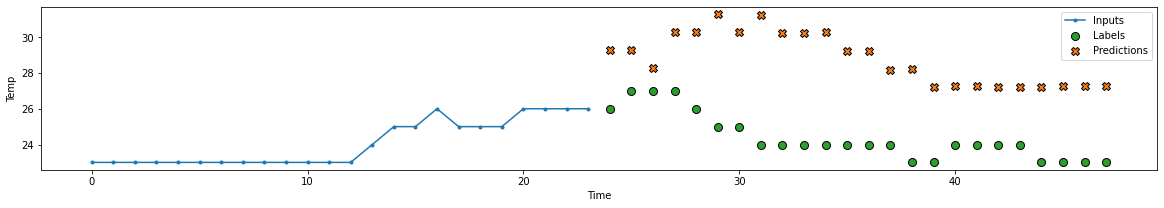

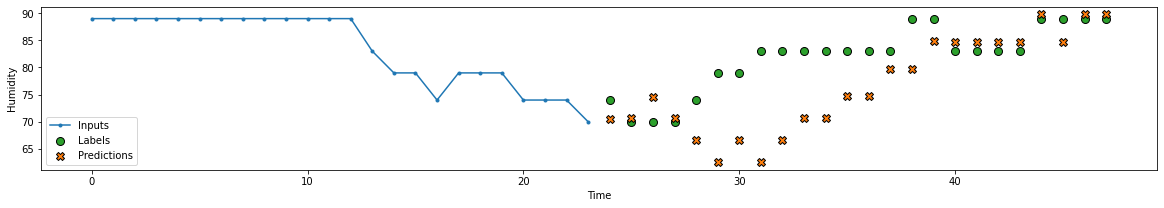

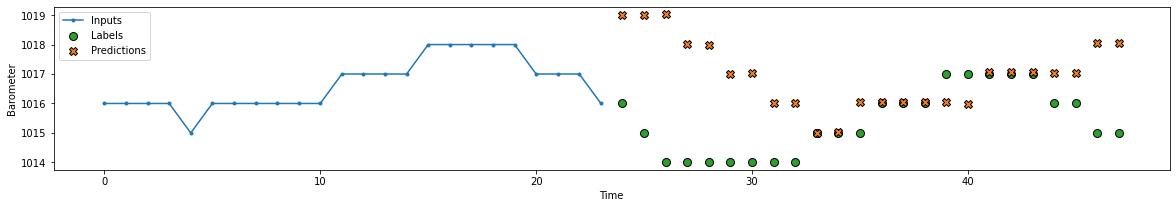

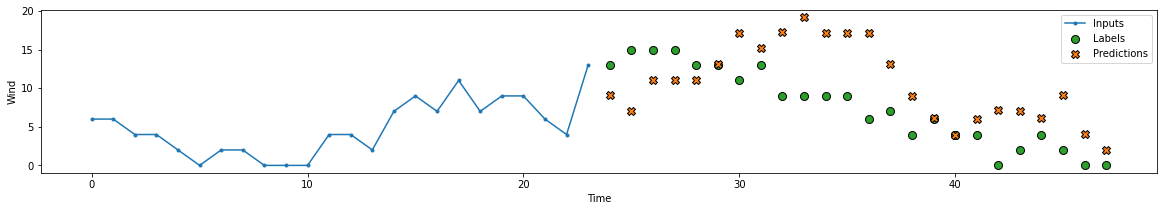

In [32]:
multi_window_list[0].plot(multi_conv_model,plot_col='Temp')
multi_window_list[0].plot(multi_conv_model,plot_col='Humidity')
multi_window_list[0].plot(multi_conv_model,plot_col='Barometer')
multi_window_list[0].plot(multi_conv_model,plot_col='Wind')

#### 2.Model Dense

In [33]:
history = compile_and_fit(multi_dense_model, multi_window_list[0])
loss_dense = history.history['loss']
val_loss_dense = history.history['val_loss']

Epoch 1/200
1/1 [==============================] - 1s 649ms/step - loss: 17.4129 - r_squared: 0.9999 - mean_absolute_error: 3.2660 - val_loss: 3050.9465 - val_r_squared: 0.9830 - val_mean_absolute_error: 49.0363
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 2978.7656 - r_squared: 0.9834 - mean_absolute_error: 48.5399 - val_loss: 514.2910 - val_r_squared: 0.9971 - val_mean_absolute_error: 17.9673
Epoch 3/200
1/1 [==============================] - 0s 64ms/step - loss: 476.2667 - r_squared: 0.9974 - mean_absolute_error: 17.4585 - val_loss: 1024.9297 - val_r_squared: 0.9943 - val_mean_absolute_error: 26.8655
Epoch 4/200
1/1 [==============================] - 0s 60ms/step - loss: 1006.7090 - r_squared: 0.9944 - mean_absolute_error: 27.1857 - val_loss: 1386.1801 - val_r_squared: 0.9923 - val_mean_absolute_error: 35.1697
Epoch 5/200
1/1 [==============================] - 0s 64ms/step - loss: 1376.4542 - r_squared: 0.9923 - mean_absolute_error: 35.4831 - val_loss: 607

Epoch 40/200
1/1 [==============================] - 0s 64ms/step - loss: 15.0854 - r_squared: 0.9999 - mean_absolute_error: 3.0732 - val_loss: 29.6125 - val_r_squared: 0.9998 - val_mean_absolute_error: 3.7665
Epoch 41/200
1/1 [==============================] - 0s 60ms/step - loss: 11.6948 - r_squared: 0.9999 - mean_absolute_error: 2.7537 - val_loss: 35.9106 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.5416
Epoch 42/200
1/1 [==============================] - 0s 104ms/step - loss: 18.0795 - r_squared: 0.9999 - mean_absolute_error: 3.6419 - val_loss: 43.2492 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.8456
Epoch 43/200
1/1 [==============================] - 0s 56ms/step - loss: 23.1797 - r_squared: 0.9999 - mean_absolute_error: 3.6681 - val_loss: 41.6712 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.7737
Epoch 44/200
1/1 [==============================] - 0s 64ms/step - loss: 18.1172 - r_squared: 0.9999 - mean_absolute_error: 3.1312 - val_loss: 35.7858 - val_r_squa

1/1 [==============================] - 0s 65ms/step - loss: 0.0052 - r_squared: 1.0000 - mean_absolute_error: 0.0604 - val_loss: 23.2100 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9935
Epoch 119/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0074 - r_squared: 1.0000 - mean_absolute_error: 0.0635 - val_loss: 23.0863 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9832
Epoch 120/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0093 - r_squared: 1.0000 - mean_absolute_error: 0.0666 - val_loss: 23.1281 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9785
Epoch 121/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0048 - r_squared: 1.0000 - mean_absolute_error: 0.0496 - val_loss: 23.2918 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9852
Epoch 122/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0023 - r_squared: 1.0000 - mean_absolute_error: 0.0387 - val_loss: 23.4517 - val_r_squared: 0.9999 - v

Epoch 157/200
1/1 [==============================] - 0s 64ms/step - loss: 1.1335e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0083 - val_loss: 23.2905 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9849
Epoch 158/200
1/1 [==============================] - 0s 56ms/step - loss: 7.7053e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0071 - val_loss: 23.2919 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9848
Epoch 159/200
1/1 [==============================] - 0s 57ms/step - loss: 1.2084e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0090 - val_loss: 23.3050 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9858
Epoch 160/200
1/1 [==============================] - 0s 64ms/step - loss: 1.0883e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0081 - val_loss: 23.3188 - val_r_squared: 0.9999 - val_mean_absolute_error: 2.9871
Epoch 161/200
1/1 [==============================] - 0s 64ms/step - loss: 8.5023e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0075 - val_loss: 2

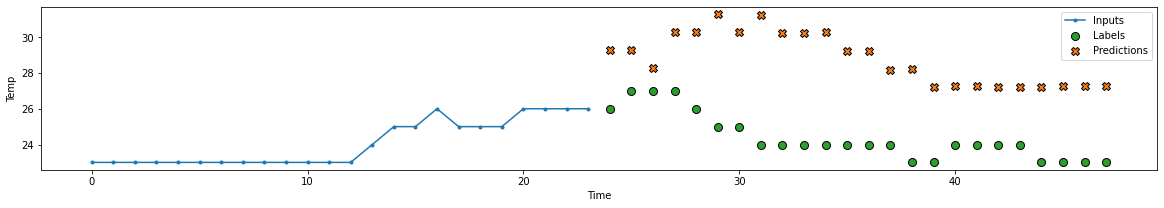

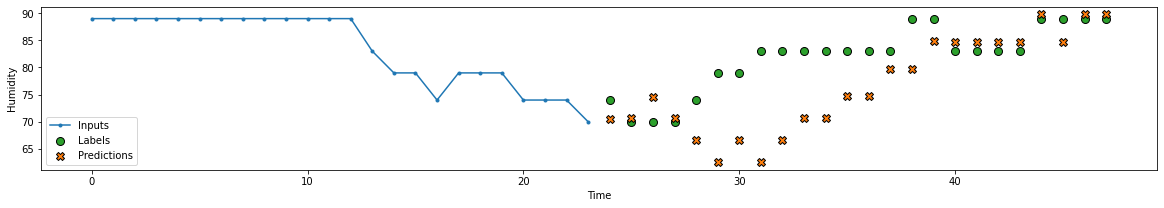

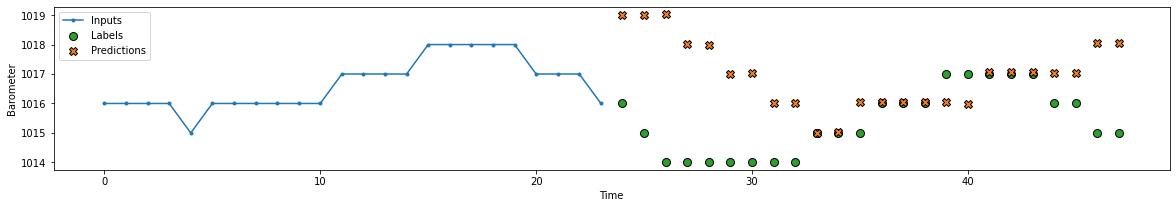

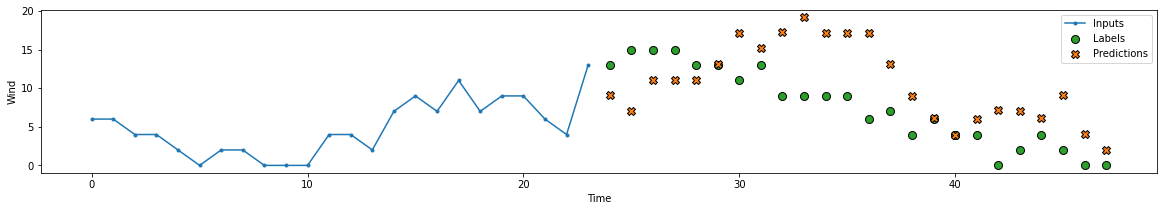

In [34]:
multi_window_list[0].plot(multi_conv_model,plot_col='Temp')
multi_window_list[0].plot(multi_conv_model,plot_col='Humidity')
multi_window_list[0].plot(multi_conv_model,plot_col='Barometer')
multi_window_list[0].plot(multi_conv_model,plot_col='Wind')

#### 3.Model CNN

In [35]:
history = compile_and_fit(multi_conv_model, multi_window_list[0])
loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']

Epoch 1/200
1/1 [==============================] - 1s 681ms/step - loss: 20.3953 - r_squared: 0.9999 - mean_absolute_error: 3.8487 - val_loss: 4102.4668 - val_r_squared: 0.9772 - val_mean_absolute_error: 60.0491
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 3939.0022 - r_squared: 0.9781 - mean_absolute_error: 59.1538 - val_loss: 349.4541 - val_r_squared: 0.9981 - val_mean_absolute_error: 17.0449
Epoch 3/200
1/1 [==============================] - 0s 64ms/step - loss: 287.9685 - r_squared: 0.9984 - mean_absolute_error: 16.1337 - val_loss: 927.2347 - val_r_squared: 0.9948 - val_mean_absolute_error: 28.4884
Epoch 4/200
1/1 [==============================] - 0s 73ms/step - loss: 965.2935 - r_squared: 0.9946 - mean_absolute_error: 29.3766 - val_loss: 2188.2302 - val_r_squared: 0.9878 - val_mean_absolute_error: 44.1925
Epoch 5/200
1/1 [==============================] - 0s 56ms/step - loss: 2257.9319 - r_squared: 0.9874 - mean_absolute_error: 45.0740 - val_loss: 1243.

Epoch 40/200
1/1 [==============================] - 0s 64ms/step - loss: 7.1350 - r_squared: 1.0000 - mean_absolute_error: 2.3599 - val_loss: 40.8097 - val_r_squared: 0.9998 - val_mean_absolute_error: 4.7673
Epoch 41/200
1/1 [==============================] - 0s 56ms/step - loss: 8.2009 - r_squared: 1.0000 - mean_absolute_error: 2.4583 - val_loss: 63.6394 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.4832
Epoch 42/200
1/1 [==============================] - 0s 64ms/step - loss: 27.0907 - r_squared: 0.9998 - mean_absolute_error: 4.6810 - val_loss: 71.5197 - val_r_squared: 0.9996 - val_mean_absolute_error: 6.9525
Epoch 43/200
1/1 [==============================] - 0s 57ms/step - loss: 35.5993 - r_squared: 0.9998 - mean_absolute_error: 5.3153 - val_loss: 54.4455 - val_r_squared: 0.9997 - val_mean_absolute_error: 5.9329
Epoch 44/200
1/1 [==============================] - 0s 56ms/step - loss: 23.1162 - r_squared: 0.9999 - mean_absolute_error: 4.1673 - val_loss: 30.9566 - val_r_squared

1/1 [==============================] - 0s 64ms/step - loss: 0.0154 - r_squared: 1.0000 - mean_absolute_error: 0.1044 - val_loss: 24.5683 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2778
Epoch 119/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0076 - r_squared: 1.0000 - mean_absolute_error: 0.0744 - val_loss: 24.6458 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3035
Epoch 120/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0032 - r_squared: 1.0000 - mean_absolute_error: 0.0420 - val_loss: 24.6830 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3243
Epoch 121/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0082 - r_squared: 1.0000 - mean_absolute_error: 0.0754 - val_loss: 24.6580 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3273
Epoch 122/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0100 - r_squared: 1.0000 - mean_absolute_error: 0.0846 - val_loss: 24.5904 - val_r_squared: 0.9999 - v

Epoch 157/200
1/1 [==============================] - 0s 64ms/step - loss: 1.2097e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0087 - val_loss: 24.5842 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2977
Epoch 158/200
1/1 [==============================] - 0s 62ms/step - loss: 1.1390e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0088 - val_loss: 24.5976 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.3002
Epoch 159/200
1/1 [==============================] - 0s 57ms/step - loss: 1.9415e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0114 - val_loss: 24.5934 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2992
Epoch 160/200
1/1 [==============================] - 0s 64ms/step - loss: 1.4392e-04 - r_squared: 1.0000 - mean_absolute_error: 0.0102 - val_loss: 24.5760 - val_r_squared: 0.9999 - val_mean_absolute_error: 3.2957
Epoch 161/200
1/1 [==============================] - 0s 56ms/step - loss: 6.6000e-05 - r_squared: 1.0000 - mean_absolute_error: 0.0055 - val_loss: 2

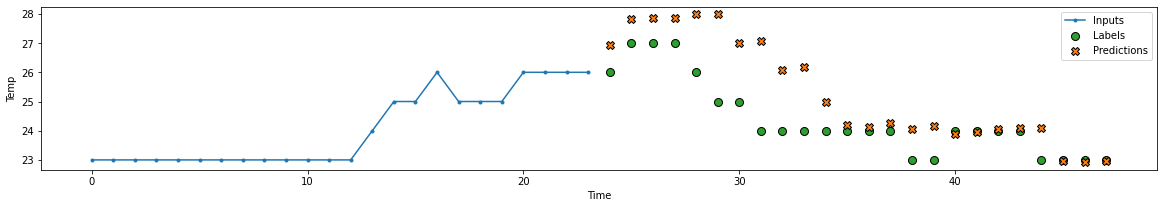

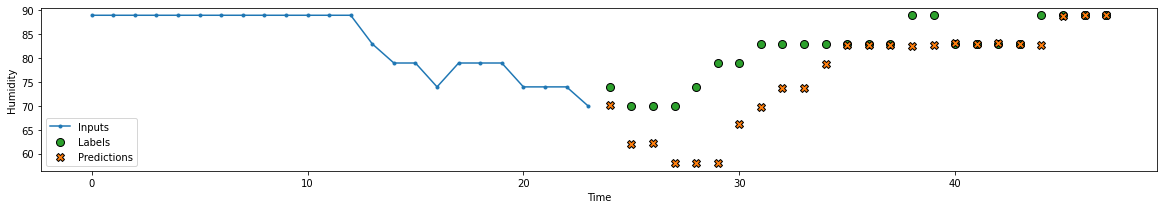

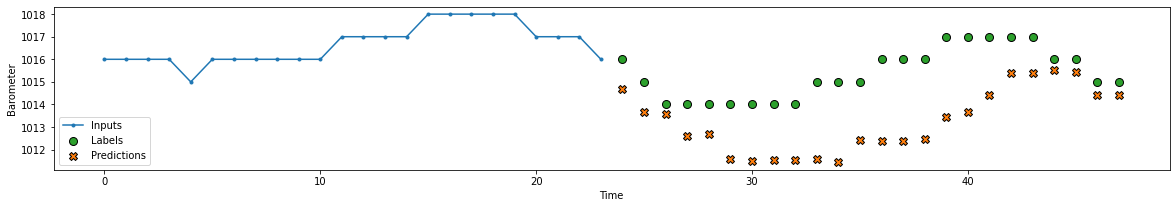

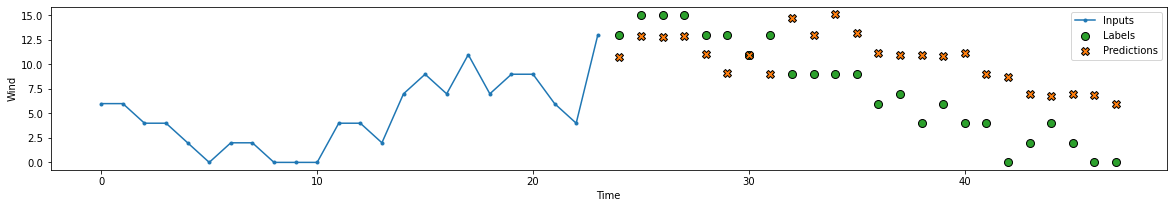

In [36]:
multi_window_list[0].plot(multi_conv_model,plot_col='Temp')
multi_window_list[0].plot(multi_conv_model,plot_col='Humidity')
multi_window_list[0].plot(multi_conv_model,plot_col='Barometer')
multi_window_list[0].plot(multi_conv_model,plot_col='Wind')

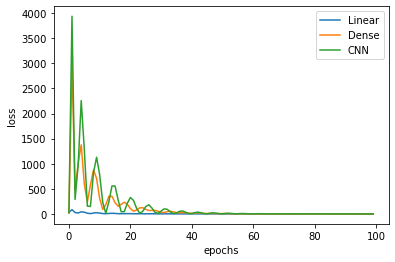

<Figure size 576x936 with 0 Axes>

In [37]:
# Vẽ đồ thị
# Chỉnh kích thước đồ thị
plt.plot(loss_linear[0:100], label='Linear')
plt.plot(loss_dense[0:100], label='Dense')
plt.plot(loss_CNN[0:100], label='CNN')

# Đặt tên trục x và trục y
plt.xlabel('epochs')
plt.ylabel('loss')

# Thêm chú thích
plt.legend()
plt.figure(figsize=(8, 13))
# Hiển thị đồ thị
plt.show()